In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import random
from tensorflow.keras import models, Model, Sequential
from tensorflow.keras.layers import LSTM, Input, GRU, SimpleRNN, Bidirectional, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score

2024-06-21 14:29:42.284217: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-21 14:29:42.284313: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-21 14:29:42.413184: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [3]:
df = pd.read_csv('./data.csv')

In [4]:
df.isna().mean()

Date        0.000000
Price       0.000000
Open        0.000000
High        0.000000
Low         0.000000
Vol.        0.001936
Change %    0.000000
dtype: float64

In [5]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,12/30/2022,"1,826.20","1,821.80","1,832.40","1,819.80",107.50K,0.01%
1,12/29/2022,"1,826.00","1,812.30","1,827.30","1,811.20",105.99K,0.56%
2,12/28/2022,"1,815.80","1,822.40","1,822.80","1,804.20",118.08K,-0.40%
3,12/27/2022,"1,823.10","1,808.20","1,841.90","1,808.00",159.62K,0.74%
4,12/26/2022,"1,809.70","1,805.80","1,811.95","1,805.55",NaN,0.30%


## 1. EDA

### Preprocessing data

- Loại bỏ những dữ liệu thiếu do có ít dữ liệu thiếu

In [6]:
df = df.dropna()

- Chuẩn hóa chuỗi sang số

In [7]:
# Những feature cần chuẩn hóa sang số
num_cols = ['Price', 'Open', 'Low', 'High']

# Loại bỏ dấu , ở các feature số
df[num_cols] = df[num_cols].replace({',':''}, regex=True)

# Loại bỏ dấu , và ký tự K = 1000 ở feature Volumne
df['Vol.'] = df['Vol.'].replace({'K': '', '\.':''}, regex=True)

# Do feature 'Change %' là phần trăm thay đổi ngày hôm nay so với ngày trước đó 
df = df.drop(labels='Change %', axis=1)

- Chuyển đổi dữ liệu cột Date từ object sang datetime

In [8]:
# Convert kiểu dữ liệu feature 'Date' từ object sang datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort values 
df.sort_values(by='Date', ascending=True, inplace=True)

# Reset lại index do có 1 số row bị drop
df.reset_index(drop=True, inplace=True)

- Chuyển đổi dữ liệu các cột số từ object float

In [9]:
# Convert kiểu từ liệu các feature số từ object sang float
df[list(df.columns[1:])] = df[list(df.columns[1:])].astype('float64')

In [10]:
df.dtypes

Date     datetime64[ns]
Price           float64
Open            float64
High            float64
Low             float64
Vol.            float64
dtype: object

In [11]:
df.head(10)

,Date,Price,Open,High,Low,Vol.
0,2013-01-02,1689.9,1675.8,1695.0,1672.1,6.0
1,2013-01-03,1675.6,1688.0,1689.3,1664.3,19.0
2,2013-01-04,1649.9,1664.4,1664.4,1630.0,31.0
3,2013-01-07,1647.2,1657.3,1663.8,1645.3,9.0
4,2013-01-08,1663.2,1651.5,1662.6,1648.8,13.0
5,2013-01-09,1656.5,1660.7,1664.2,1652.3,16.0
6,2013-01-10,1679.0,1656.7,1679.2,1656.7,14.0
7,2013-01-11,1661.6,1674.8,1675.7,1655.0,19.0
8,2013-01-14,1670.4,1662.3,1675.2,1662.3,18.0
9,2013-01-15,1684.9,1669.7,1685.3,1669.2,23.0


- Biểu đồ thể hiện sự thay đổi giá vàng từ năm 2013-2022

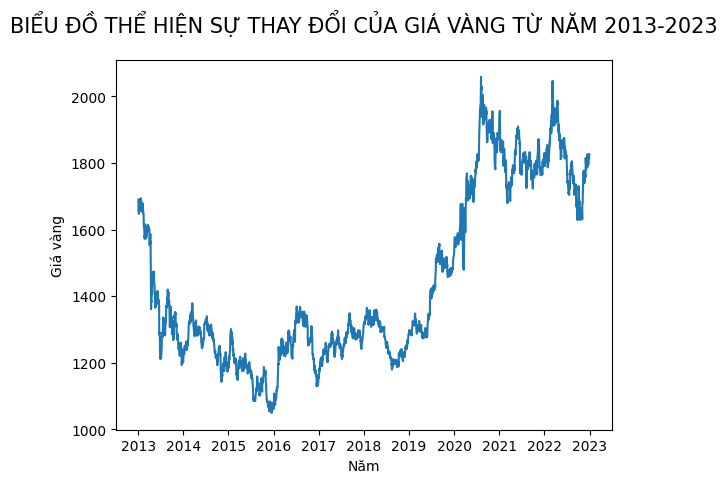

In [12]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x='Date', y='Price', ax=ax);
ax.set_title(label='Biểu đồ thể hiện sự thay đổi của giá vàng từ năm 2013-2023'.upper(), pad=20, size=15);
plt.xlabel('Năm');
plt.ylabel('Giá vàng');

- Sử dụng dữ liệu test năm 2022

In [13]:
TEST_SIZE = df[df.Date.dt.year==2022].shape[0]
TEST_SIZE

256

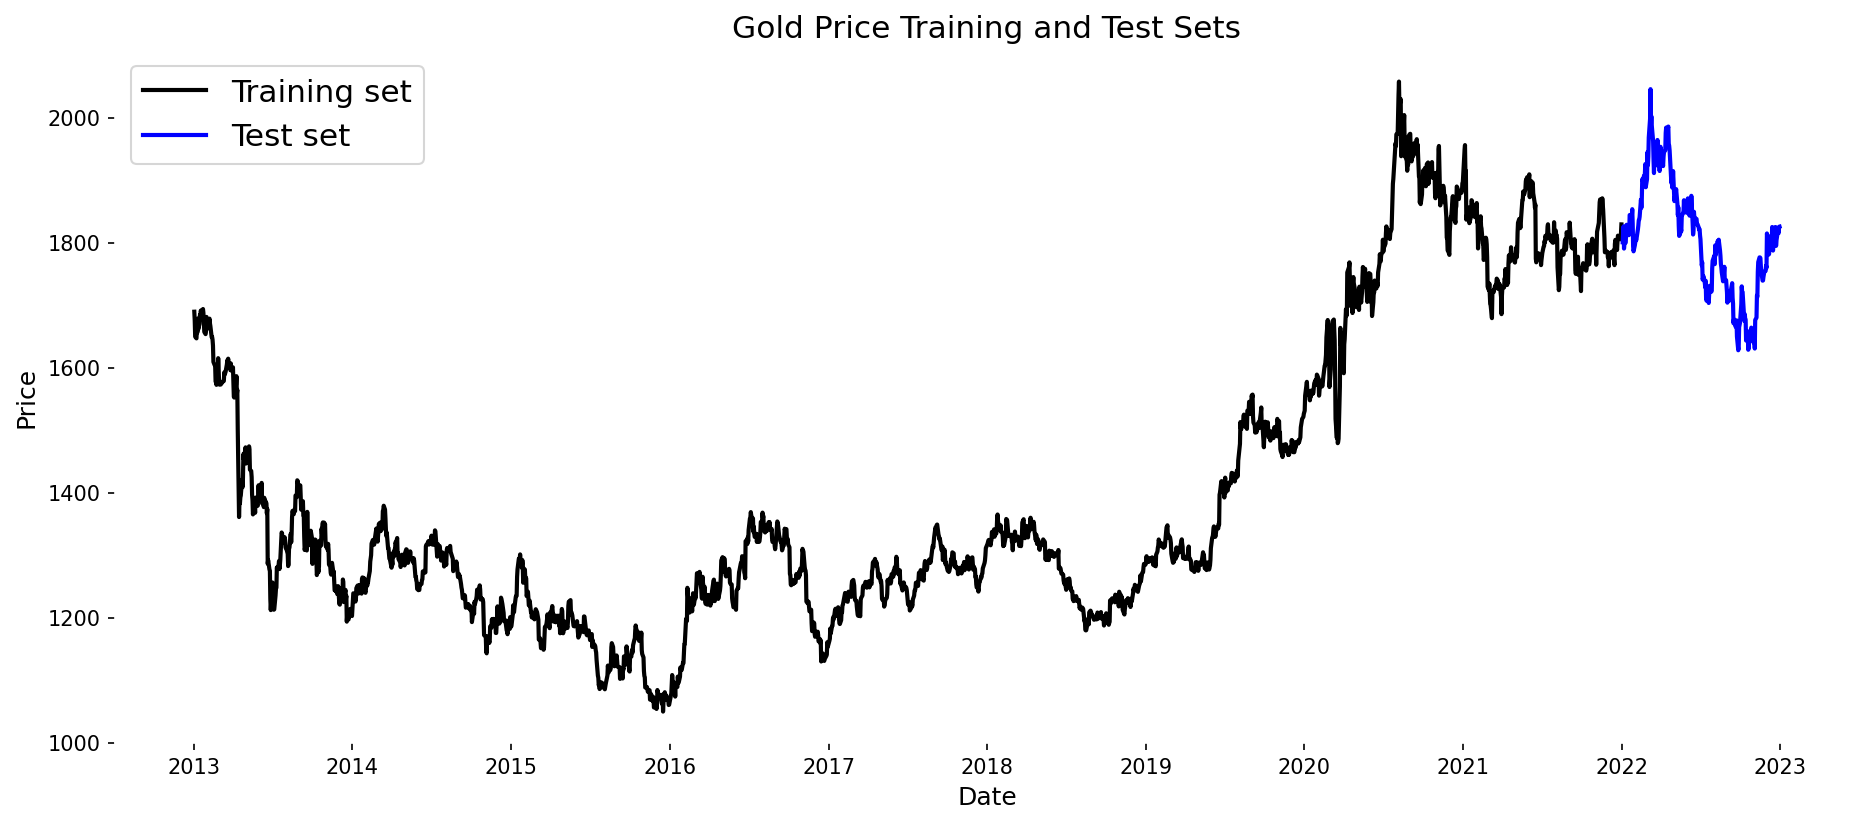

In [14]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df.Date[:-TEST_SIZE], df.Price[:-TEST_SIZE], color='black', lw=2)
plt.plot(df.Date[-TEST_SIZE:], df.Price[-TEST_SIZE:], color='blue', lw=2)
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

- Đánh giá mô hình qua 4 độ đo:
    1. R2: Đánh giá mức độ tốt của mô hình hồi quy
    2. RMSE: Đánh giá biên độ dao động giữa giá trị dự báo xung quanh giá trị thực tế
    3. MAE: Trung bình sai số giữa giá trị dự báo và giá trị thực tế
    4. MAPE: Phần trăm lỗi giữa giá trị dự đoán và giá trị thực tế

In [15]:
def measure_metric(y_true, y_pred):
    e = y_true - y_pred
    r2=r2_score(y_true, y_pred)
    mse=np.mean(e**2)
    rmse=np.sqrt(mse)
    mae=np.mean(np.abs(e))
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print('R2: {}'.format(r2))
    print('MSE: {}'.format(mse))
    print('RMSE: {}'.format(rmse))
    print('MAE: {}'.format(mae))
    print('MAPE: {}'.format(mape))
    return [r2, mse, rmse, mae, mape]

In [16]:
dict_one_step = {
    'R2': [],
    'MSE': [],
    'RMSE': [],
    'MAE': [],
    'MAPE': []
}

dict_multi_steps = {
    'R2': [],
    'MSE': [],
    'RMSE': [],
    'MAE': [],
    'MAPE': []
}

In [17]:
metric_df_one_step = pd.DataFrame(dict_one_step)
metric_df_multi_steps = pd.DataFrame(dict_multi_steps)

## 2. Single Step Forecasting
- Từ số look back dự đoán 1 điểm dữ liệu trong tương lại (VD: Từ 14 ngày dự đoán ngày thứ 15 tiếp theo)

##### Chuẩn bị dữ liệu

In [18]:
class OneStep:
    
    def __init__(self, data: pd.DataFrame, look_back=10):
        """
        Tham số:
            data (pd.DataFrame): Dữ liệu
            mapping_steps (int): Số lượng thời gian look back
        """
        # Lưu dữ liệu thành array thay vì DataFrame
        self.df = data.copy()
        self.data = self.df.values

        # Scaler dữ liệu
        self.scaler = StandardScaler()
        self.normalized_data = self.scaler.fit_transform(self.data)
        
        # Số lượng mẫu trong tập dữ liệu
        self.time_steps = data.shape[0] 
        
        # Số lượng đặc trưng
        self.n_columns = data.shape[1]

        # Số lượng ngày để dự đoán look_back -> output 
        self.look_back = look_back

    def data_mapping(self):
        """
        Chuyển từ 2D array sang 3D array để fit vào mô hình
        Với mỗi chuỗi có look_back thời gian tương ứng với số ngày trong bộ dữ liệu 
    
        Tham số:
            look_back (int): Số lượng thời gian cho từng chuỗi.
    
        Trả về:
            1 Array 3D với shape (mapping_iterations, look_back, n_columns).
        """
        mapping_steps = self.look_back + 1
        
        iterations = self.time_steps - mapping_steps + 1
        self.normalized_data_mapped = np.empty((iterations, mapping_steps, self.n_columns))
        
        for i in range(iterations):
            self.normalized_data_mapped[i, :, :] = self.normalized_data[i:i + mapping_steps, :]
        
        return self.normalized_data_mapped
    
    def train_test_split(self, test_size):
        """
        Chia tập dữ liệu thành tập train và test.
        
        Tham số:
            test_size (int): Số lượng quan sát thời gian cho tập test.
        
        Trả về:
            tuple: X_train, X_test, y_train, y_test
        """
        self.test_size = test_size
        self.train_size = self.normalized_data_mapped.shape[0] - self.test_size
        
        # normalized_data_mapped đã chứa số look_back+1 nên chỉ việc lấy look_back ở phần trước cho tập train và để lại giá trị cuối cùng là của tập test
        X_train = self.normalized_data_mapped[:self.train_size, :-1, :]
        y_train = self.normalized_data_mapped[:self.train_size, -1, :]
        
        X_test = self.normalized_data_mapped[self.train_size:, :-1, :]
        y_test = self.normalized_data_mapped[self.train_size:, -1, :]
        
        return X_train, X_test, y_train, y_test  

    def forecast_n_steps(self, model, data: pd.DataFrame, n_forecast_steps=15):
        """
        Dự đoán nhiều điểm dữ liệu tiếp theo bằng cách từ model dự đoán 1 step. Bỏ dữ liệu ban đầu từ chuỗi look back sau đó đưa dữ liệu vừa dự đoán
        vào cuối của chuỗi look back để dự đoán tiếp theo. Lặp lại cho đến khi dự đoán được đủ n_forecast_steps
    
        Tham số:
            model: Mô hình để dự đoán.
            data: 1 chuỗi look back bất kì để phán đoán step tiếp theo của look back.
            n_forecast_steps: Số lượng step được dự đoán tiếp sau chuỗi look back.
    
        Trả về:
            np.array: 1 tập n_forecast_steps đã dự đoán.
        """
        # Scaling dữ liệu của chuỗi look back. last_steps shape = (self.look_back, self.n_columns)
        last_steps = self.scaler.transform(data.values)[-self.look_back:]
    
        # Định nghĩa 1 mẫu dữ liệu để dữ đoán output với shape = (n_forecast_steps, self.look_back, self.n_columns) để có thể fit từng mẫu vào mô hình dự đoán ra output
        normalized_data_mapped = np.empty((n_forecast_steps, self.look_back, self.n_columns))
    
        # Khởi tạo tập dự đoán chứa n_forecast_steps dự đoán từ mô hình
        predictions = np.empty((n_forecast_steps, self.n_columns))
    
        # Dự đoán trước 1 step
        normalized_data_mapped[0, :, :] = last_steps
        predictions[0, :] = model.predict(
            normalized_data_mapped[0, :, :].reshape(1, self.look_back, self.n_columns),
            verbose=False
        )
        # Tạo ra n_forecast_steps dự đoán mới từ look back và 1 step đã dự đoán
        for i in range(1, n_forecast_steps):
            # Loại bỏ quan sát ở đầu ra và thêm phán đoán mới vào chuỗi
            normalized_data_mapped[i, :-1, :] = normalized_data_mapped[i - 1, 1:, :]
            normalized_data_mapped[i, -1, :] = predictions[i - 1, :]
    
            # Dự đoán quan sát tiếp theo
            norm_data = normalized_data_mapped[i, :, :].reshape(1, self.look_back, self.n_columns)
            predictions[i, :] = model.predict(norm_data, verbose=False)
    
        # Inverse dữ liệu 
        predictions = self.scaler.inverse_transform(predictions)
        return predictions

- Các đặc trưng dùng để training

In [19]:
columns = ['Price', 'Open', 'Low', 'High', 'Vol.']

In [20]:
# Từ 30 điểm thời gian trước đó dự đoán ra điểm thời gian thứ 31 tiếp theo
look_back = 30

# Fit dữ liệu để setup dữ liệu cho mô hình
data_model_one_step = OneStep(df[columns], look_back)

# Scaled dữ liệu
scaled_data_mapped = data_model_one_step.data_mapping()

- test_size = 256: tương ứng với giá vàng năm 2022

In [21]:
X_train_one_step, X_test_one_step, y_train_one_step, y_test_one_step = data_model_one_step.train_test_split(test_size=TEST_SIZE)

In [22]:
X_train_one_step.shape, X_test_one_step.shape, y_train_one_step.shape, y_test_one_step.shape

((2292, 30, 5), (256, 30, 5), (2292, 5), (256, 5))

In [23]:
# # For consistant results
# random.seed(0)
# np.random.seed(0)
# tf.random.set_seed(0)

#### 2.1 Mô hình LSTM one step

##### Định nghĩa mô hình

In [24]:
def lstm_one_step_model():
    input = Input(shape=X_train_one_step[0].shape)
    x = LSTM(units=128, return_sequences=True)(input)
    x = Dropout(0.1)(x)
    x = LSTM(units=64, return_sequences=False)(x)
    x = Dropout(0.1)(x)
    x = Dense(units=32, activation='relu')(x)
    output = Dense(units=len(columns))(x)
    
    model = Model(inputs=input, outputs=[output])
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    
    return model

In [25]:
model1 = lstm_one_step_model()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 128)        │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,261 (469.77 KB)

 Trainable params: 120,261 (469.77 KB)

 Non-trainable params: 0 (0.00 B)

##### Đưa dữ liệu vào mô hình học
- Lựa chọn tham số
    + epochs = 50, số lần học toàn bộ tập train
    + batch_size = 64, mỗi iteration sẽ training 64 mẫu
    + validation_split = 0.1, lấy 10% số dự liệu tập train làm dữ liệu validate

In [26]:
model_checkpoint1 = ModelCheckpoint('model1.keras', monitor='val_loss', save_best_only=True)

In [27]:
history1 = model1.fit(  X_train_one_step, 
                        y_train_one_step, 
                        epochs=50, 
                        batch_size=128, 
                        validation_data=(X_test_one_step, y_test_one_step), 
                        verbose=False,
                        callbacks=[model_checkpoint1])

- Đánh giá tốc độ học của mô hình

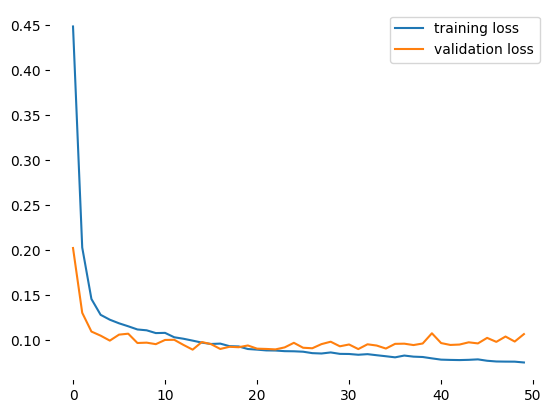

In [28]:
plt.plot(history1.history['loss'], label = 'training loss')
plt.plot(history1.history['val_loss'], label ='validation loss')
plt.legend()
plt.show()

- Đường màu xanh cho thấy mô hình đã học khá nhanh sau 1 vài epochs đầu
- Đường màu cam giảm thấp hơn tức là mô hình có mức độ khái quát cao và không bị overfitting

- Đánh giá mô hình trên tập test và phán đoán trên tập test

In [29]:
model1 = models.load_model(f'model1.keras')

In [30]:
result1 = model1.evaluate(X_test_one_step, y_test_one_step)
y_pred_model1 = model1.predict(X_test_one_step)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0907  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


- Sử dụng metric đánh giá mô hình
    + MAPE: phần trăm sai số giữa giá trị dự báo và giá trị thực tế 

In [31]:
y_test_true_one_step = data_model_one_step.scaler.inverse_transform(y_test_one_step).T[0]
y_test_pred_model1 = data_model_one_step.scaler.inverse_transform(y_pred_model1).T[0]

In [32]:
MAPE = mean_absolute_percentage_error(y_test_true_one_step, y_test_pred_model1)
Accuracy = 1 - MAPE
print(f"Phần trăm sai số giữa giá trị dự báo và giá trị thực tế {MAPE * 100}")
print(f"Độ chính xác của mô hình: {Accuracy * 100}")

Phần trăm sai số giữa giá trị dự báo và giá trị thực tế 1.490095897263791
Độ chính xác của mô hình: 98.50990410273621


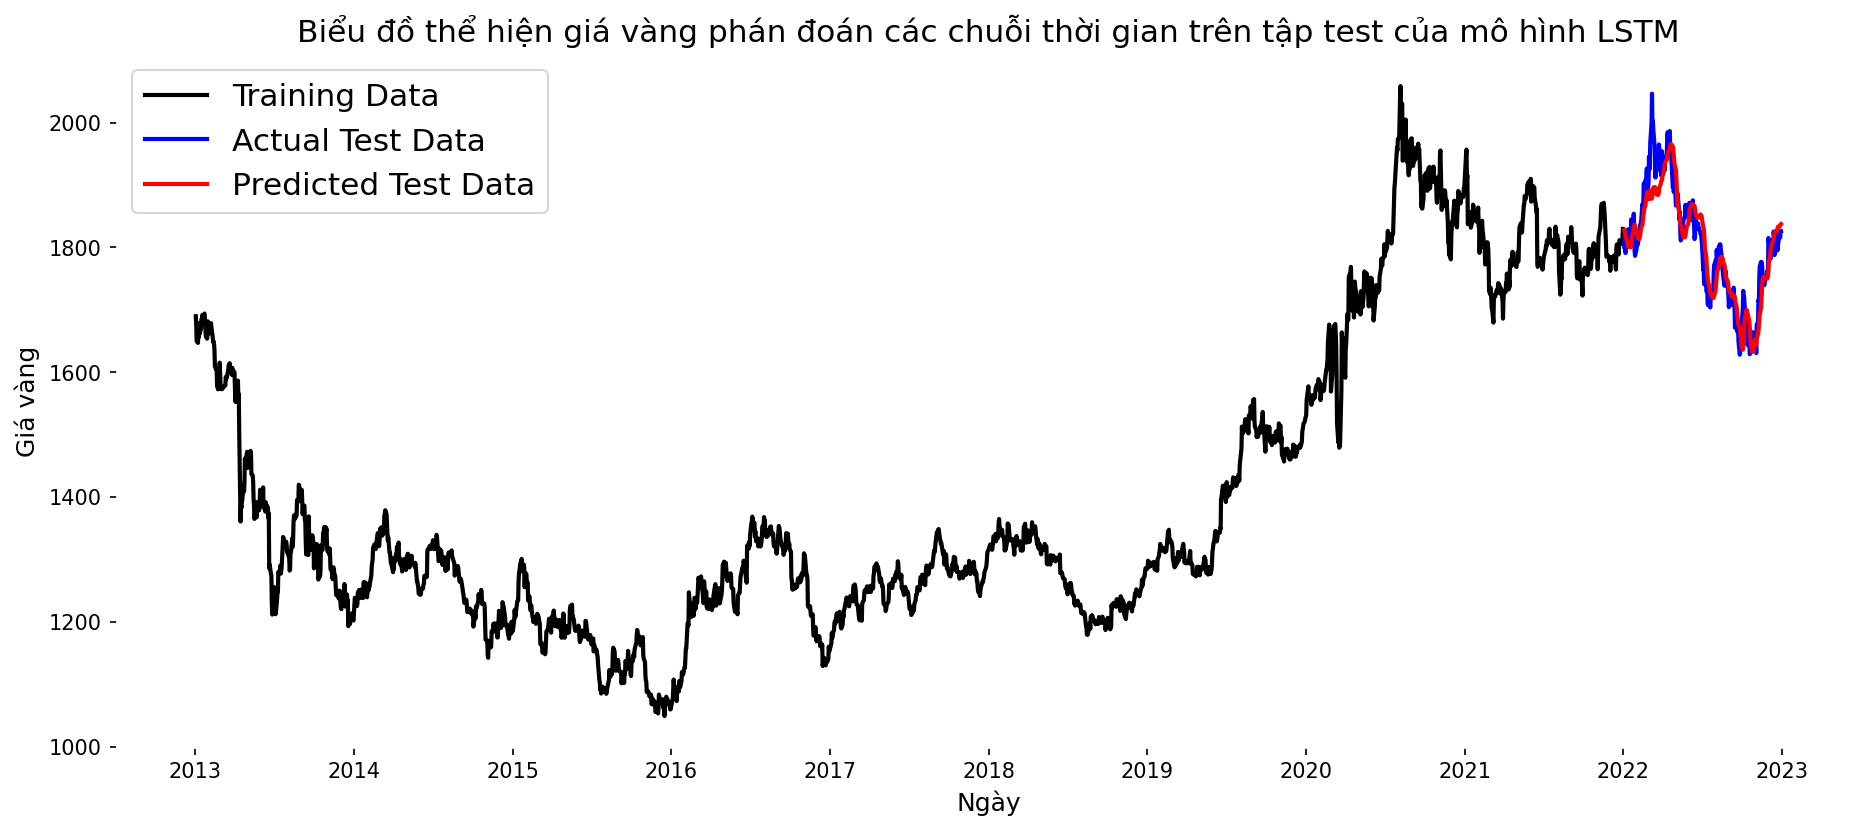

In [33]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-TEST_SIZE], df['Price'].iloc[:-TEST_SIZE], color='black', lw=2)
plt.plot(df['Date'].iloc[-TEST_SIZE:], y_test_true_one_step, color='blue', lw=2)
plt.plot(df['Date'].iloc[-TEST_SIZE:], y_test_pred_model1, color='red', lw=2)
plt.title('Biểu đồ thể hiện giá vàng phán đoán các chuỗi thời gian trên tập test của mô hình LSTM', fontsize=15)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá vàng', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [34]:
print(f"Biên độ giao động của giá trị dự báo xung quanh giá trị thực tế là {((y_test_true_one_step - y_test_pred_model1) **2).mean()**(1/2)}")

Biên độ giao động của giá trị dự báo xung quanh giá trị thực tế là 35.7510006997731


In [35]:
metric_df_one_step.loc[len(metric_df_one_step.index)] = measure_metric(y_test_true_one_step, y_test_pred_model1)

R2: 0.8470137380549891
MSE: 1278.134051035177
RMSE: 35.7510006997731
MAE: 27.11472511291504
MAPE: 0.01490095897263791


#### Dự đoán n giá trị trong tương lai từ mô hình LSTM one step

- Dự đoán 15 ngày tiếp theo trong tương lai từ mô hình bằng cách lấy các giá trị phán đoán của mô hình đưa vào chuỗi phán đoán tiếp tục đến khi đủ 15 ngày

In [36]:
n_steps = 15

In [37]:
n_steps_data = df[columns].iloc[-(look_back + n_steps): -n_steps, :]

In [38]:
n_steps_prediction_model1 = data_model_one_step.forecast_n_steps(model1, n_steps_data, n_steps)

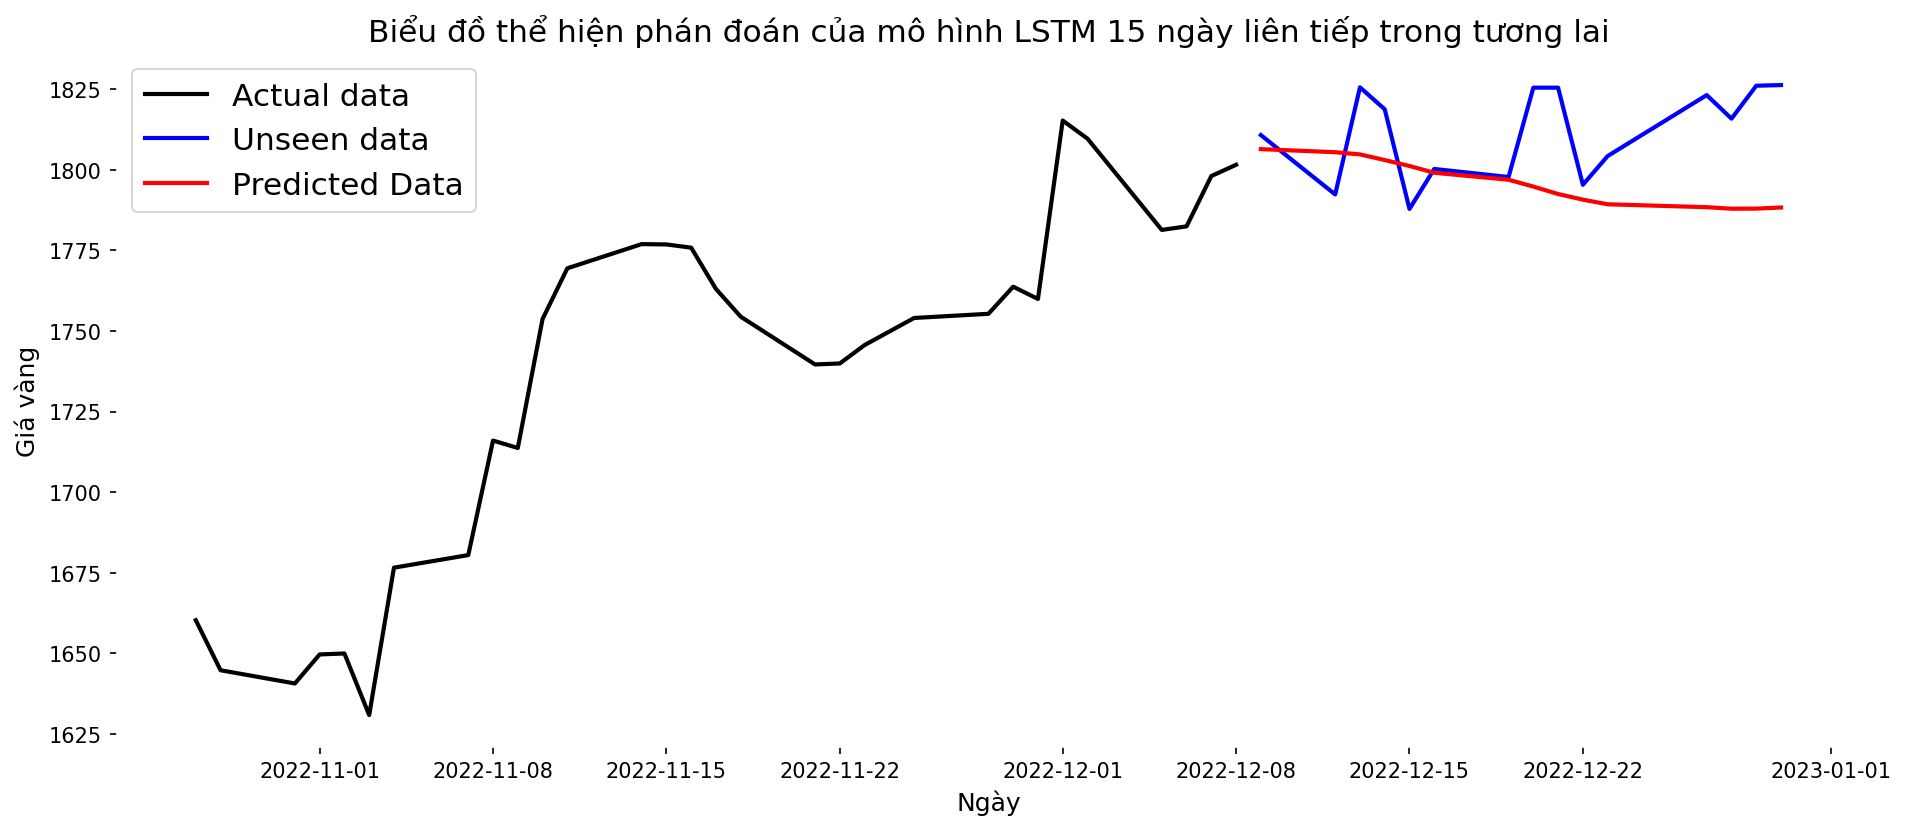

In [39]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[-(look_back + n_steps): -n_steps], df['Price'].iloc[-(look_back + n_steps): -n_steps], color='black', lw=2)
plt.plot(df['Date'].iloc[-n_steps:], df['Price'].iloc[-n_steps:], color='blue', lw=2)
plt.plot(df['Date'].iloc[-n_steps:], n_steps_prediction_model1.T[0], color='red', lw=2)
plt.title(f'Biểu đồ thể hiện phán đoán của mô hình LSTM {n_steps} ngày liên tiếp trong tương lai', fontsize=15)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá vàng', fontsize=12)
plt.legend(['Actual data', 'Unseen data', 'Predicted Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [40]:
print(f"Biên độ giao động của giá trị dự báo xung quanh giá trị thực tế là {((df['Price'].iloc[-n_steps:].values - n_steps_prediction_model1.T[0]) **2).mean()**(1/2)}")

Biên độ giao động của giá trị dự báo xung quanh giá trị thực tế là 23.382265244417233


- Dựa vào biên độ giao động có thể thấy mô hình đưa ra các phán đoán cho các giá trị thời gian tương lai xa hơn 1 bị sai lệch rất nhiều vào đường dự đoán (đường màu đỏ theo biểu đồ) gần như là đường tuyến tính

#### 2.2. Mô hình GRU one step

##### Định nghĩa mô hình

In [41]:
def gru_one_step_model():
    input = Input(shape=X_train_one_step[0].shape)
    x = GRU(units=128, return_sequences=True)(input)
    x = Dropout(0.1)(x)
    x = GRU(units=64, return_sequences=False)(x)
    x = Dropout(0.1)(x)
    x = Dense(units=32, activation='relu')(x)
    output = Dense(units=len(columns))(x)
    
    model = Model(inputs=input, outputs=[output])
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    
    return model

In [42]:
model2 = gru_one_step_model()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 30, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 30, 128)        │        51,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,333 (356.77 KB)

 Trainable params: 91,333 (356.77 KB)

 Non-trainable params: 0 (0.00 B)

##### Đưa dữ liệu vào mô hình học
- Lựa chọn tham số
    + epochs = 50, số lần học toàn bộ tập train
    + batch_size = 64, mỗi iteration sẽ training 64 mẫu
    + validation_split = 0.1, lấy 10% số dự liệu tập train làm dữ liệu validate

In [43]:
model_checkpoint2 = ModelCheckpoint('model2.keras', monitor='val_loss', save_best_only=True)

In [44]:
history2 = model2.fit(X_train_one_step, 
                      y_train_one_step, 
                      epochs=50, 
                      batch_size=128, 
                      validation_data=(X_test_one_step, y_test_one_step), 
                      verbose=False,
                      callbacks=[model_checkpoint2])

- Đánh giá tốc độ học của mô hình

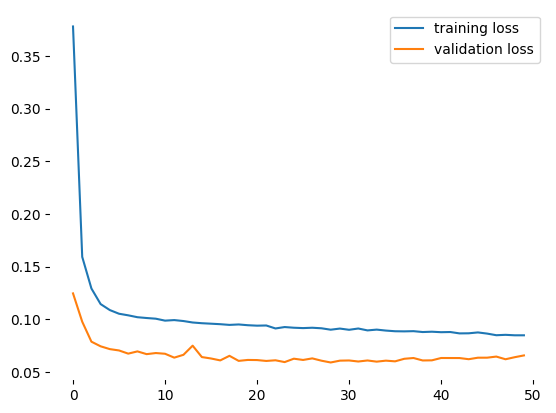

In [45]:
plt.plot(history2.history['loss'], label = 'training loss')
plt.plot(history2.history['val_loss'], label ='validation loss')
plt.legend()
plt.show()

- Đường màu xanh cho thấy mô hình đã học khá nhanh sau 1 vài epochs đầu
- Đường màu cam giảm thấp hơn tức là mô hình có mức độ khái quát cao và không bị overfitting

- Đánh giá mô hình trên tập test và phán đoán trên tập test

In [46]:
model2 = models.load_model(f'model2.keras')

In [47]:
result2 = model2.evaluate(X_test_one_step, y_test_one_step)
y_pred_model2 = model2.predict(X_test_one_step)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0707  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


- Sử dụng metric đánh giá mô hình
    + MAPE: phần trăm sai số giữa giá trị dự báo và giá trị thực tế 

In [48]:
y_test_pred_model2 = data_model_one_step.scaler.inverse_transform(y_pred_model2).T[0]
MAPE = mean_absolute_percentage_error(y_test_true_one_step, y_test_pred_model2)
Accuracy = 1 - MAPE
print(f"Phần trăm sai số giữa giá trị dự báo và giá trị thực tế {MAPE * 100}")
print(f"Độ chính xác của mô hình: {Accuracy * 100}")

Phần trăm sai số giữa giá trị dự báo và giá trị thực tế 0.8950739879744065
Độ chính xác của mô hình: 99.1049260120256


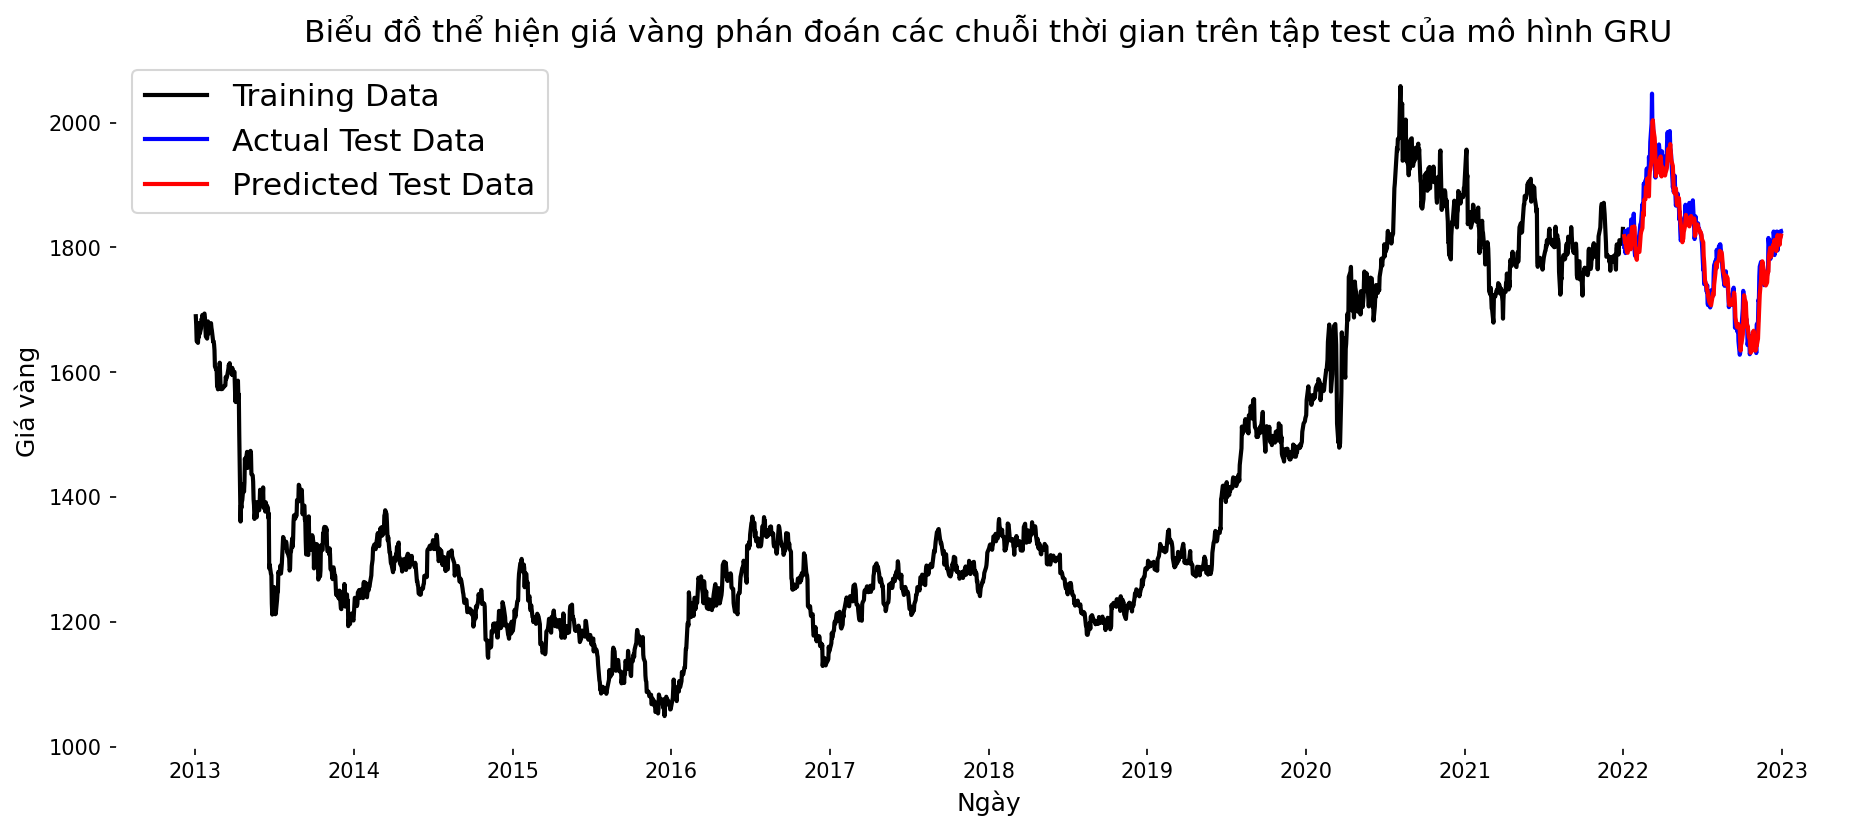

In [49]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-TEST_SIZE], df['Price'].iloc[:-TEST_SIZE], color='black', lw=2)
plt.plot(df['Date'].iloc[-TEST_SIZE:], y_test_true_one_step, color='blue', lw=2)
plt.plot(df['Date'].iloc[-TEST_SIZE:], y_test_pred_model2, color='red', lw=2)
plt.title('Biểu đồ thể hiện giá vàng phán đoán các chuỗi thời gian trên tập test của mô hình GRU', fontsize=15)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá vàng', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [50]:
print(f"Biên độ giao động của giá trị dự báo xung quanh giá trị thực tế là {((y_test_true_one_step - y_test_pred_model2) **2).mean()**(1/2)}")

Biên độ giao động của giá trị dự báo xung quanh giá trị thực tế là 20.9395124120366


In [51]:
metric_df_one_step.loc[len(metric_df_one_step.index)] = measure_metric(y_test_true_one_step, y_test_pred_model2)

R2: 0.9475181473628447
MSE: 438.4631800538348
RMSE: 20.9395124120366
MAE: 16.22235488891601
MAPE: 0.008950739879744065


#### Dự đoán n giá trị trong tương lai từ mô hình GRU one step
- n_steps = 15

In [52]:
n_steps_prediction_model2 = data_model_one_step.forecast_n_steps(model2, n_steps_data, n_steps)

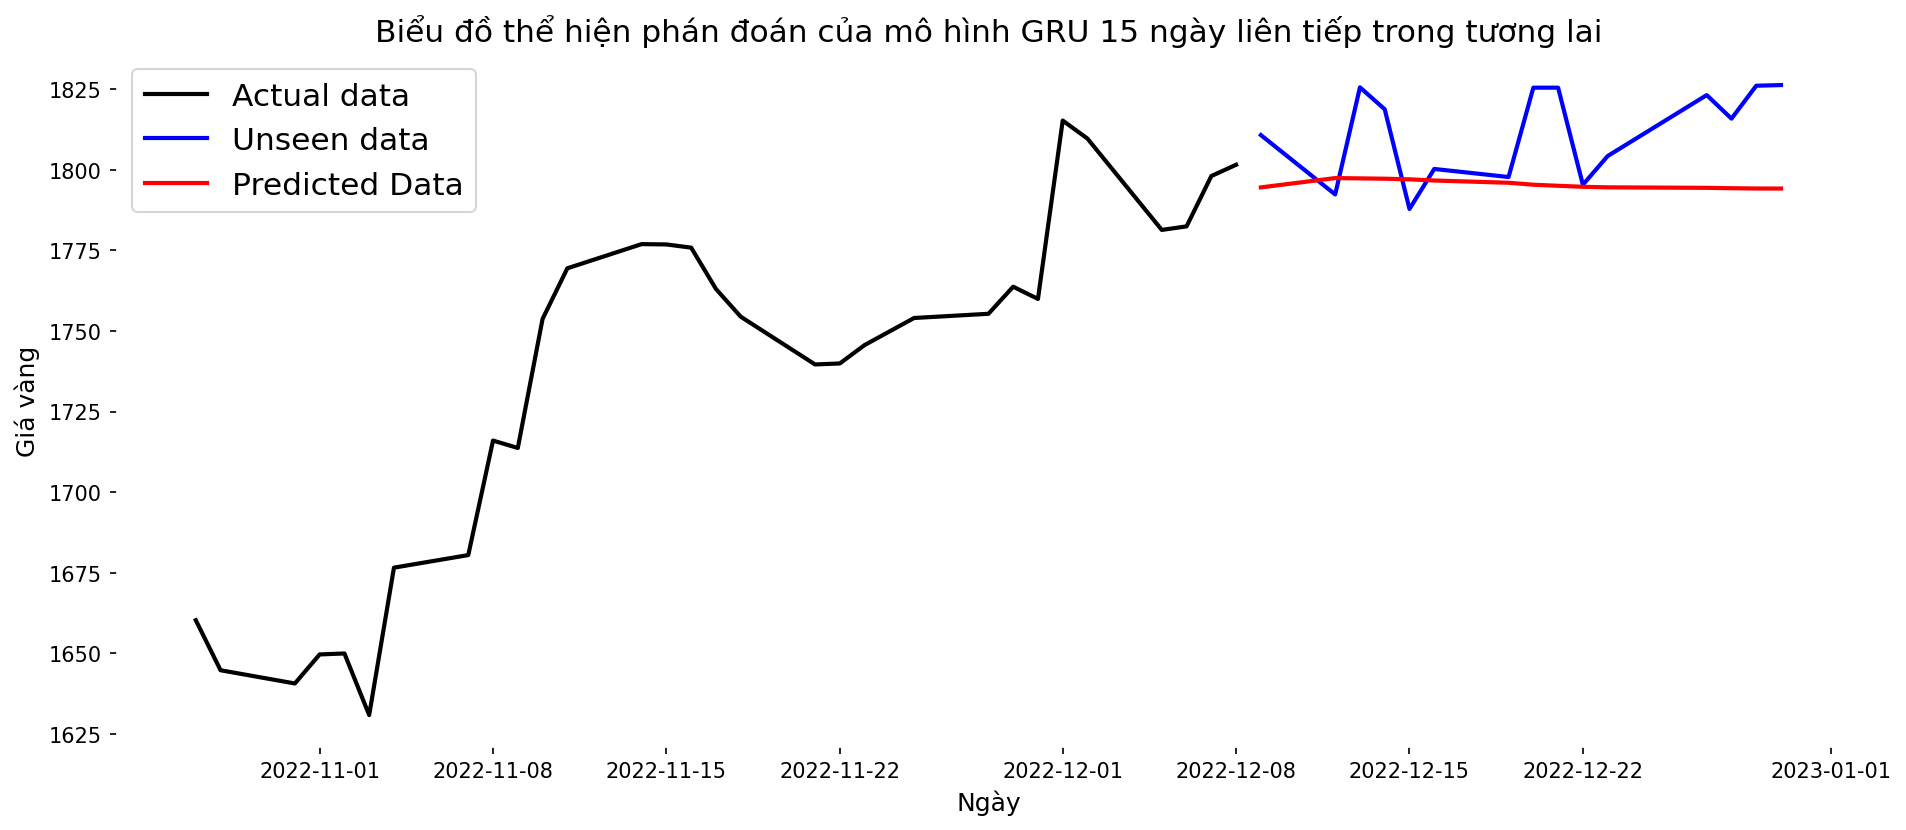

In [53]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[-(look_back + n_steps): -n_steps], df['Price'].iloc[-(look_back + n_steps): -n_steps], color='black', lw=2)
plt.plot(df['Date'].iloc[-n_steps:], df['Price'].iloc[-n_steps:], color='blue', lw=2)
plt.plot(df['Date'].iloc[-n_steps:], n_steps_prediction_model2.T[0], color='red', lw=2)
plt.title(f'Biểu đồ thể hiện phán đoán của mô hình GRU {n_steps} ngày liên tiếp trong tương lai', fontsize=15)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá vàng', fontsize=12)
plt.legend(['Actual data', 'Unseen data', 'Predicted Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

- Dựa vào biên độ giao động có thể thấy mô hình đưa ra các phán đoán cho các giá trị thời gian tương lai xa hơn 1 bị sai lệch rất nhiều vào đường dự đoán (đường màu đỏ theo biểu đồ) gần như là đường tuyến tính

In [54]:
print(f"Biên độ giao động của giá trị dự báo xung quanh giá trị thực tế là {((df['Price'].iloc[-n_steps:].values - n_steps_prediction_model2.T[0]) **2).mean()**(1/2)}")

Biên độ giao động của giá trị dự báo xung quanh giá trị thực tế là 21.46200997246007


#### 2.3. Mô hình BiLSTM one step

##### Định nghĩa mô hình

In [55]:
def bilstm_one_step_model():
    input = Input(shape=X_train_one_step[0].shape)
    x = Bidirectional(LSTM(units=64, return_sequences=False))(input)
    x = Dropout(0.1)(x)
    x = Dense(units=32, activation='relu')(x)
    output = Dense(units=len(columns))(x)
    
    model = Model(inputs=input, outputs=[output])
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    
    return model

In [56]:
model3 = bilstm_one_step_model()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 30, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        35,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,133 (156.77 KB)

 Trainable params: 40,133 (156.77 KB)

 Non-trainable params: 0 (0.00 B)

##### Đưa dữ liệu vào mô hình học
- Lựa chọn tham số
    + epochs = 50, số lần học toàn bộ tập train
    + batch_size = 64, mỗi iteration sẽ training 64 mẫu
    + validation_split = 0.1, lấy 10% số dự liệu tập train làm dữ liệu validate

In [57]:
model_checkpoint3 = ModelCheckpoint('model3.keras', monitor='val_loss', save_best_only=True)

In [58]:
history3 = model3.fit(X_train_one_step, 
                      y_train_one_step, 
                      epochs=25, 
                      batch_size=128, 
                      validation_data=(X_test_one_step, y_test_one_step), 
                      verbose=False, 
                      callbacks=[model_checkpoint3])

- Đánh giá tốc độ học của mô hình

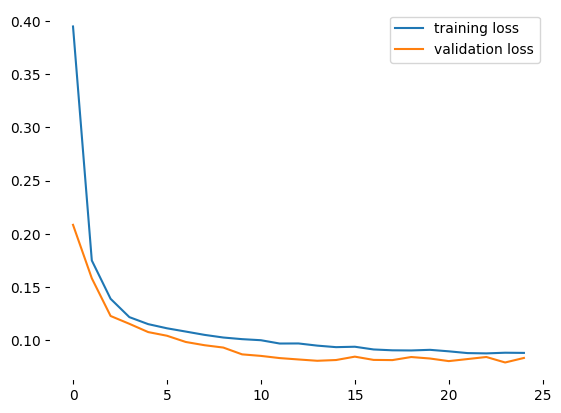

In [59]:
plt.plot(history3.history['loss'], label = 'training loss')
plt.plot(history3.history['val_loss'], label ='validation loss')
plt.legend()
plt.show()

- Đánh giá mô hình trên tập test và phán đoán trên tập test

In [60]:
model3 = models.load_model(f'model3.keras')

In [61]:
result3 = model3.evaluate(X_test_one_step, y_test_one_step)
y_pred_model3 = model3.predict(X_test_one_step)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0775  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


- Sử dụng metric đánh giá mô hình
    + MAPE: phần trăm sai số giữa giá trị dự báo và giá trị thực tế 

In [62]:
y_test_pred_model3 = data_model_one_step.scaler.inverse_transform(y_pred_model3).T[0]
MAPE = mean_absolute_percentage_error(y_test_true_one_step, y_test_pred_model3)
Accuracy = 1 - MAPE
print(f"Phần trăm sai số giữa giá trị dự báo và giá trị thực tế {MAPE * 100}")
print(f"Độ chính xác của mô hình: {Accuracy * 100}")

Phần trăm sai số giữa giá trị dự báo và giá trị thực tế 1.1438282779570488
Độ chính xác của mô hình: 98.85617172204294


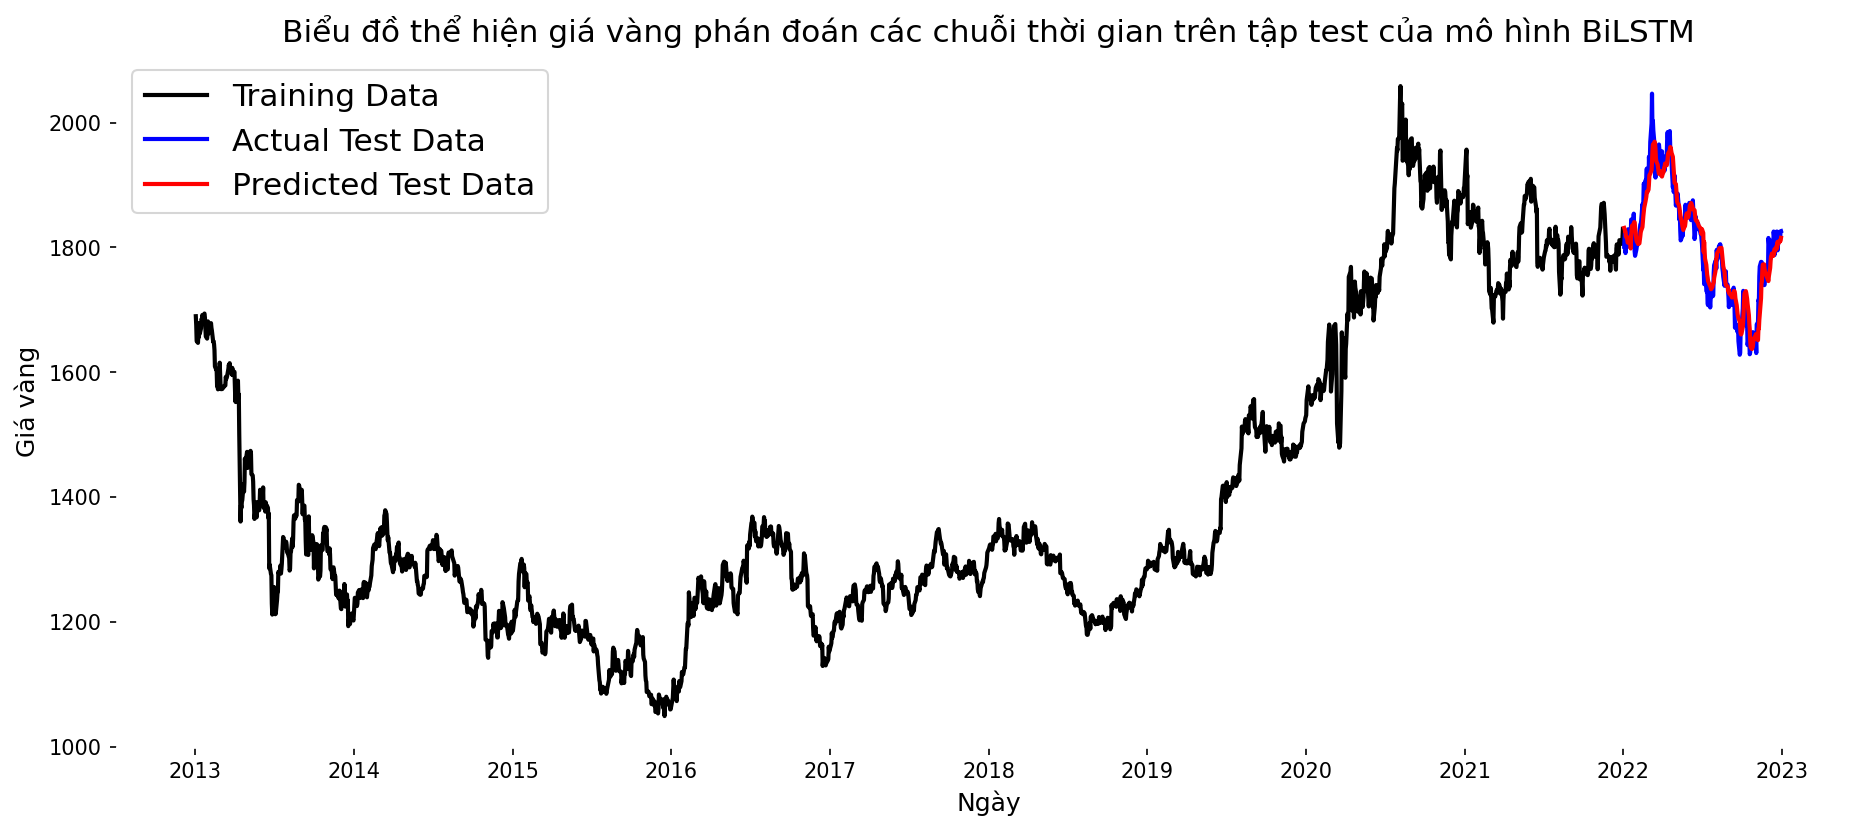

In [63]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-TEST_SIZE], df['Price'].iloc[:-TEST_SIZE], color='black', lw=2)
plt.plot(df['Date'].iloc[-TEST_SIZE:], y_test_true_one_step, color='blue', lw=2)
plt.plot(df['Date'].iloc[-TEST_SIZE:], y_test_pred_model3, color='red', lw=2)
plt.title('Biểu đồ thể hiện giá vàng phán đoán các chuỗi thời gian trên tập test của mô hình BiLSTM', fontsize=15)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá vàng', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [64]:
print(f"Biên độ giao động của giá trị dự báo xung quanh giá trị thực tế là {((y_test_true_one_step - y_test_pred_model3) **2).mean()**(1/2)}")

Biên độ giao động của giá trị dự báo xung quanh giá trị thực tế là 26.805900956796666


In [65]:
metric_df_one_step.loc[len(metric_df_one_step.index)] = measure_metric(y_test_true_one_step, y_test_pred_model3)

R2: 0.913992396776534
MSE: 718.5563261055923
RMSE: 26.805900956796666
MAE: 20.55847749710083
MAPE: 0.011438282779570487


#### Dự đoán n giá trị trong tương lai từ mô hình BiLSTM one step
- n_steps = 15

In [66]:
n_steps_prediction_model3 = data_model_one_step.forecast_n_steps(model3, n_steps_data, n_steps)

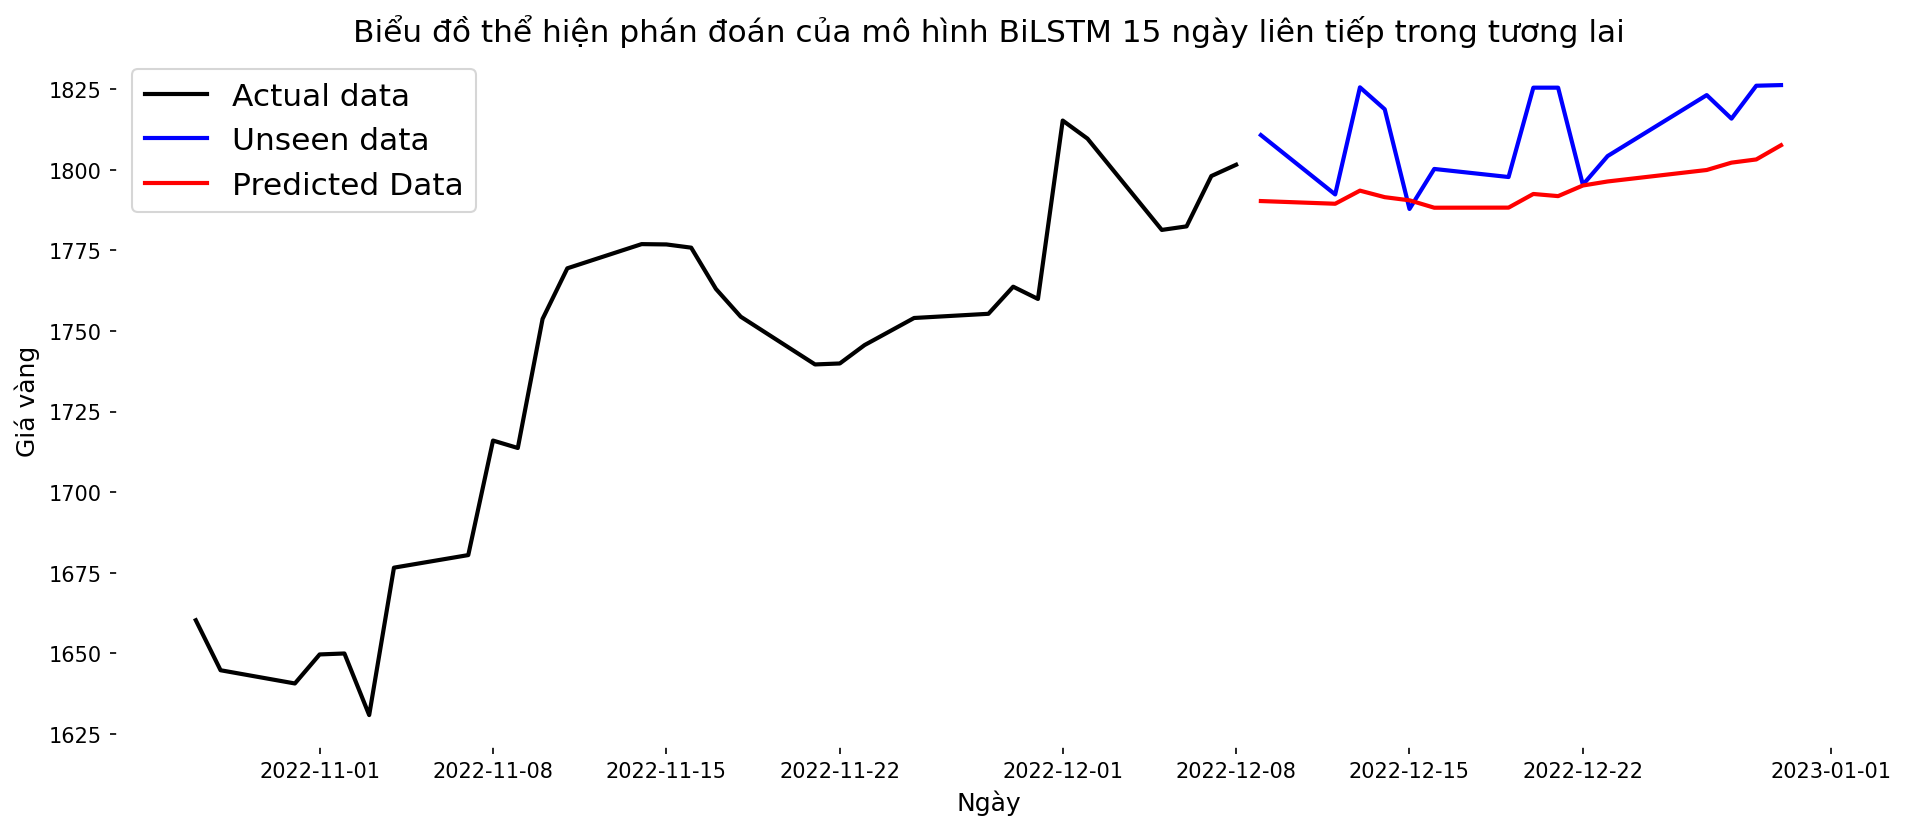

In [67]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[-(look_back + n_steps): -n_steps], df['Price'].iloc[-(look_back + n_steps): -n_steps], color='black', lw=2)
plt.plot(df['Date'].iloc[-n_steps:], df['Price'].iloc[-n_steps:], color='blue', lw=2)
plt.plot(df['Date'].iloc[-n_steps:], n_steps_prediction_model3.T[0], color='red', lw=2)
plt.title(f'Biểu đồ thể hiện phán đoán của mô hình BiLSTM {n_steps} ngày liên tiếp trong tương lai', fontsize=15)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá vàng', fontsize=12)
plt.legend(['Actual data', 'Unseen data', 'Predicted Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [68]:
print(f"Biên độ giao động của giá trị dự báo xung quanh giá trị thực tế là {((df['Price'].iloc[-n_steps:].values - n_steps_prediction_model3.T[0]) **2).mean()**(1/2)}")

Biên độ giao động của giá trị dự báo xung quanh giá trị thực tế là 20.509752453809686


#### 2.4. Mô hình CNN one step

##### Định nghĩa mô hình

In [69]:
def cnn_one_step_model():
    input = Input(shape=X_train_one_step[0].shape)
    x = Conv1D(filters=32, kernel_size=3)(input)
    x = MaxPooling1D(pool_size=3)(x)
    x = Flatten()(x)
    x = Dense(units=32, activation='relu')(x)
    output = Dense(units=len(columns))(x)
    
    model = Model(inputs=input, outputs=[output])
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    
    return model

In [70]:
model4 = cnn_one_step_model()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 30, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 28, 32)         │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 9, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,925 (38.77 KB)

 Trainable params: 9,925 (38.77 KB)

 Non-trainable params: 0 (0.00 B)

##### Đưa dữ liệu vào mô hình học
- Lựa chọn tham số
    + epochs = 50, số lần học toàn bộ tập train
    + batch_size = 64, mỗi iteration sẽ training 64 mẫu
    + validation_split = 0.1, lấy 10% số dự liệu tập train làm dữ liệu validate

In [71]:
model_checkpoint4 = ModelCheckpoint('model4.keras', monitor='val_loss', save_best_only=True)

In [72]:
history4 = model4.fit(X_train_one_step, 
                      y_train_one_step, 
                      epochs=50, 
                      batch_size=128, 
                      validation_data=(X_test_one_step, y_test_one_step), 
                      verbose=False,
                      callbacks=[model_checkpoint4])

I0000 00:00:1718980236.682722     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


- Đánh giá tốc độ học của mô hình

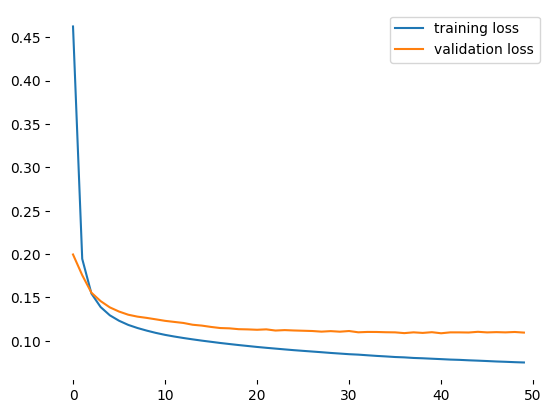

In [73]:
plt.plot(history4.history['loss'], label = 'training loss')
plt.plot(history4.history['val_loss'], label ='validation loss')
plt.legend()
plt.show()

- Đánh giá mô hình trên tập test và phán đoán trên tập test

In [74]:
model4 = models.load_model('model4.keras')

In [75]:
result4 = model4.evaluate(X_test_one_step, y_test_one_step)
y_pred_model4 = model4.predict(X_test_one_step)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0946  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


- Sử dụng metric đánh giá mô hình
    + MAPE: phần trăm sai số giữa giá trị dự báo và giá trị thực tế 

In [76]:
y_test_pred_model4 = data_model_one_step.scaler.inverse_transform(y_pred_model4).T[0]
MAPE = mean_absolute_percentage_error(y_test_true_one_step, y_test_pred_model4)
Accuracy = 1 - MAPE
print(f"Phần trăm sai số giữa giá trị dự báo và giá trị thực tế {MAPE * 100}")
print(f"Độ chính xác của mô hình: {Accuracy * 100}")

Phần trăm sai số giữa giá trị dự báo và giá trị thực tế 1.9652016706752489
Độ chính xác của mô hình: 98.03479832932474


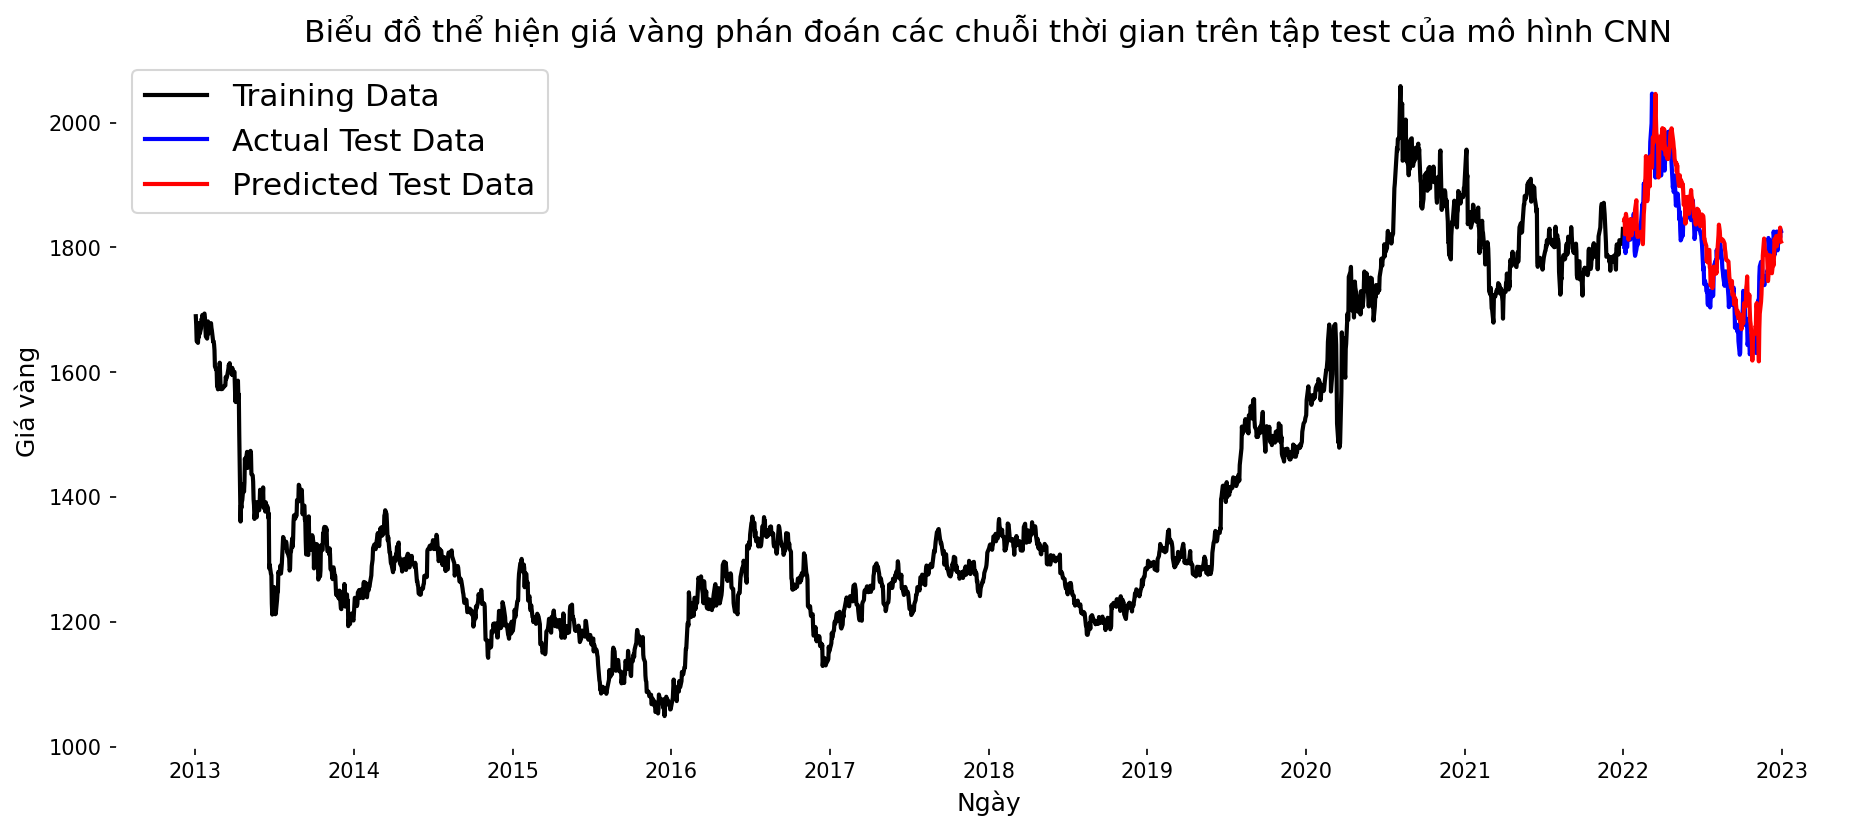

In [77]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-TEST_SIZE], df['Price'].iloc[:-TEST_SIZE], color='black', lw=2)
plt.plot(df['Date'].iloc[-TEST_SIZE:], y_test_true_one_step, color='blue', lw=2)
plt.plot(df['Date'].iloc[-TEST_SIZE:], y_test_pred_model4, color='red', lw=2)
plt.title('Biểu đồ thể hiện giá vàng phán đoán các chuỗi thời gian trên tập test của mô hình CNN', fontsize=15)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá vàng', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [78]:
print(f"Biên độ giao động của giá trị dự báo xung quanh giá trị thực tế là {((y_test_true_one_step - y_test_pred_model4) **2).mean()**(1/2)}")

Biên độ giao động của giá trị dự báo xung quanh giá trị thực tế là 42.84721690835349


In [79]:
metric_df_one_step.loc[len(metric_df_one_step.index)] = measure_metric(y_test_true_one_step, y_test_pred_model4)

R2: 0.780253855371179
MSE: 1835.8839967914928
RMSE: 42.84721690835349
MAE: 35.344340801239014
MAPE: 0.019652016706752488


#### Dự đoán n giá trị trong tương lai từ mô hình CNN one step
- n_steps = 15

In [80]:
n_steps_prediction_model4 = data_model_one_step.forecast_n_steps(model4, n_steps_data, n_steps)

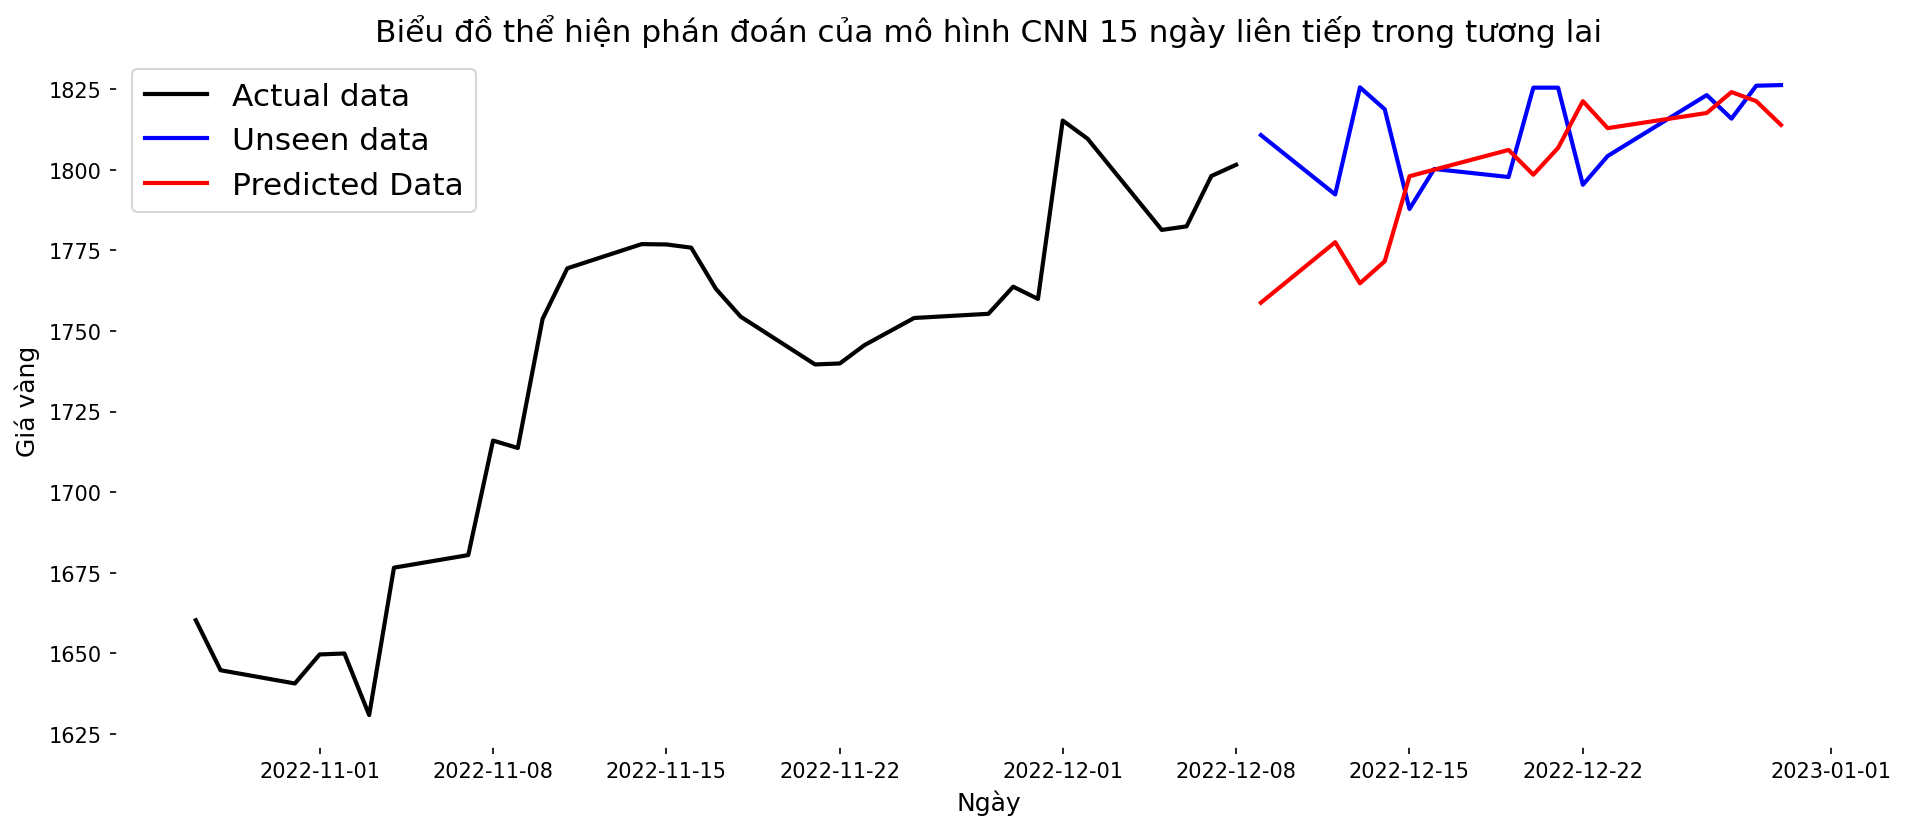

In [81]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[-(look_back + n_steps): -n_steps], df['Price'].iloc[-(look_back + n_steps): -n_steps], color='black', lw=2)
plt.plot(df['Date'].iloc[-n_steps:], df['Price'].iloc[-n_steps:], color='blue', lw=2)
plt.plot(df['Date'].iloc[-n_steps:], n_steps_prediction_model4.T[0], color='red', lw=2)
plt.title(f'Biểu đồ thể hiện phán đoán của mô hình CNN {n_steps} ngày liên tiếp trong tương lai', fontsize=15)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá vàng', fontsize=12)
plt.legend(['Actual data', 'Unseen data', 'Predicted Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [82]:
print(f"Biên độ giao động của giá trị dự báo xung quanh giá trị thực tế là {((df['Price'].iloc[-n_steps:].values - n_steps_prediction_model4.T[0]) **2).mean()**(1/2)}")

Biên độ giao động của giá trị dự báo xung quanh giá trị thực tế là 27.203662292092474


### 2.5. Mô hình CNN+LSTM one step

In [83]:
def cnnlstm_one_step_model():
    input = Input(shape=X_train_one_step[0].shape)
    x = Conv1D(filters=32, kernel_size=3, activation='relu')(input)
    x = MaxPooling1D(pool_size=3)(x)
    x = LSTM(units=50, return_sequences=False)(x)
    x = Flatten()(x)
    x = Dense(units=32, activation='relu')(x)
    output = Dense(units=len(columns))(x)
    model = Model(inputs=input, outputs=[output])
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    return model

In [84]:
model9 = cnnlstm_one_step_model()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 30, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 28, 32)         │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 9, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        16,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,909 (73.86 KB)

 Trainable params: 18,909 (73.86 KB)

 Non-trainable params: 0 (0.00 B)

In [85]:
model_checkpoint9 = ModelCheckpoint('model9.keras', monitor='val_loss', save_best_only=True)

In [86]:
history9 = model9.fit(X_train_one_step, 
                      y_train_one_step, 
                      epochs=50, 
                      batch_size=128, 
                      validation_data=(X_test_one_step, y_test_one_step), 
                      verbose=False,
                      callbacks=[model_checkpoint9]
                      )

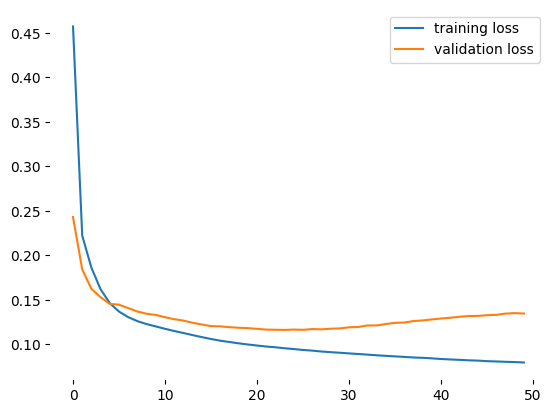

In [87]:
plt.plot(history9.history['loss'], label = 'training loss')
plt.plot(history9.history['val_loss'], label ='validation loss')
plt.legend()
plt.show()

In [88]:
model9 = models.load_model('model9.keras')

In [89]:
result9 = model9.evaluate(X_test_one_step, y_test_one_step)
y_pred_model9 = model9.predict(X_test_one_step)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1006  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


In [90]:
y_test_pred_model9 = data_model_one_step.scaler.inverse_transform(y_pred_model9).T[0]
MAPE = mean_absolute_percentage_error(y_test_true_one_step, y_test_pred_model9)
Accuracy = 1 - MAPE
print(f"Phần trăm sai số giữa giá trị dự báo và giá trị thực tế {MAPE * 100}")
print(f"Độ chính xác của mô hình: {Accuracy * 100}")

Phần trăm sai số giữa giá trị dự báo và giá trị thực tế 2.374062826687397
Độ chính xác của mô hình: 97.62593717331261


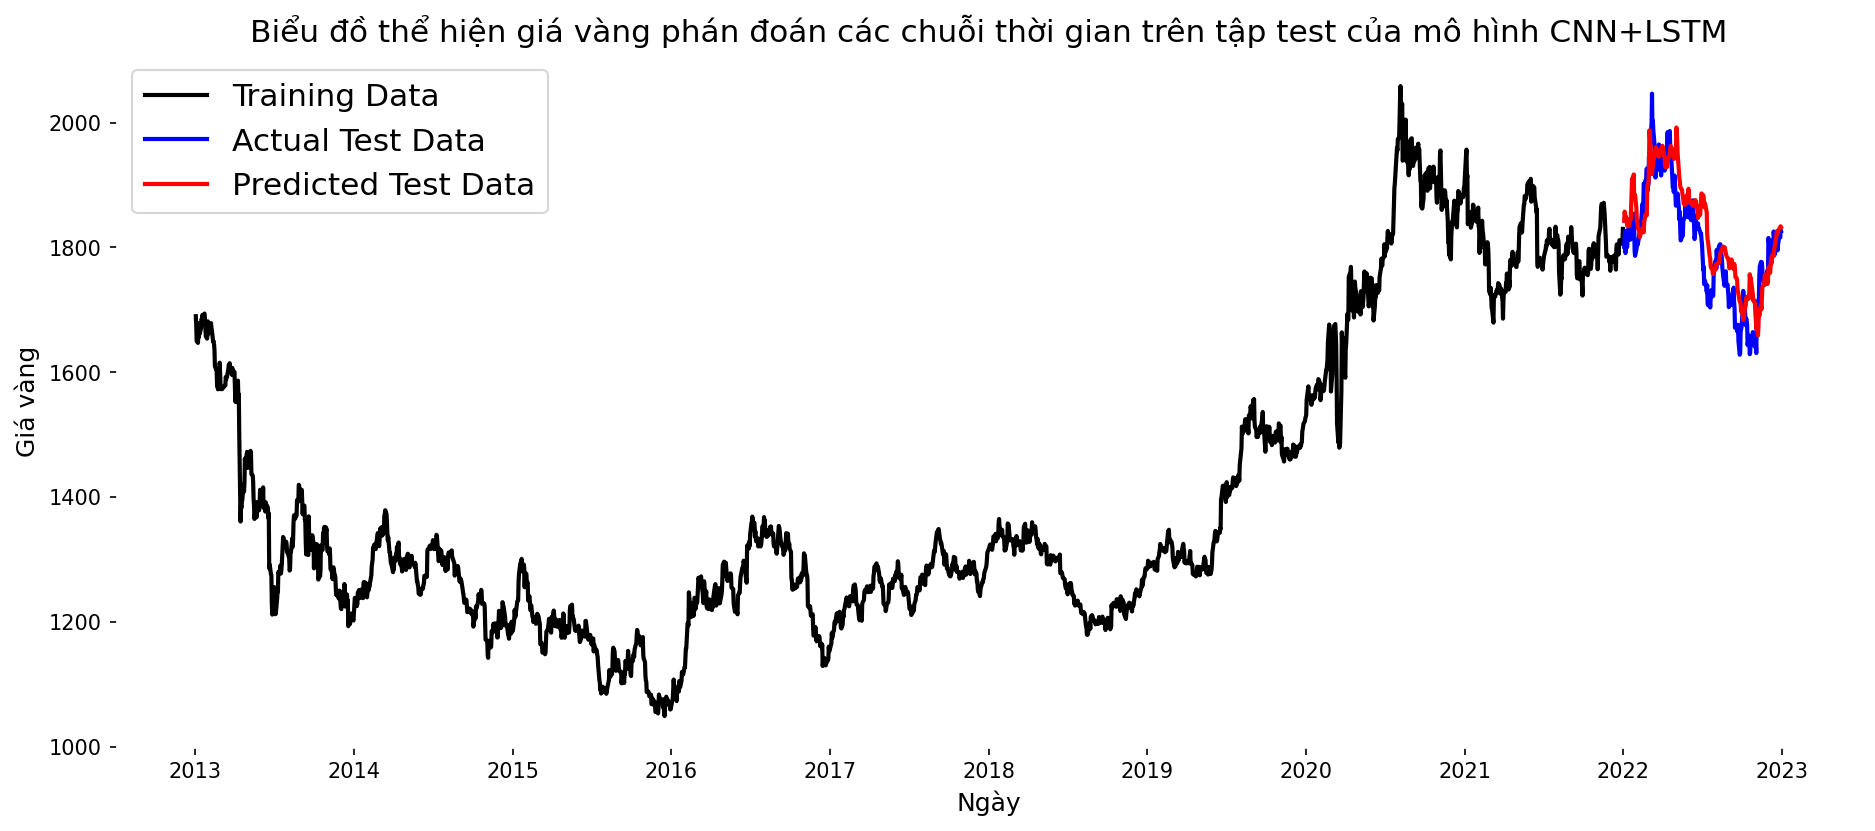

In [91]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-TEST_SIZE], df['Price'].iloc[:-TEST_SIZE], color='black', lw=2)
plt.plot(df['Date'].iloc[-TEST_SIZE:], y_test_true_one_step, color='blue', lw=2)
plt.plot(df['Date'].iloc[-TEST_SIZE:], y_test_pred_model9, color='red', lw=2)
plt.title('Biểu đồ thể hiện giá vàng phán đoán các chuỗi thời gian trên tập test của mô hình CNN+LSTM', fontsize=15)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá vàng', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [92]:
metric_df_one_step.loc[len(metric_df_one_step.index)] = measure_metric(y_test_true_one_step, y_test_pred_model9)

R2: 0.6772962008081895
MSE: 2696.0506708355574
RMSE: 51.92350788261091
MAE: 42.301879501342775
MAPE: 0.02374062826687397


#### Dự đoán n giá trị trong tương lai từ mô hình CNN+LSTM one step
- n_steps = 15

In [93]:
n_steps_prediction_model9 = data_model_one_step.forecast_n_steps(model9, n_steps_data, n_steps)

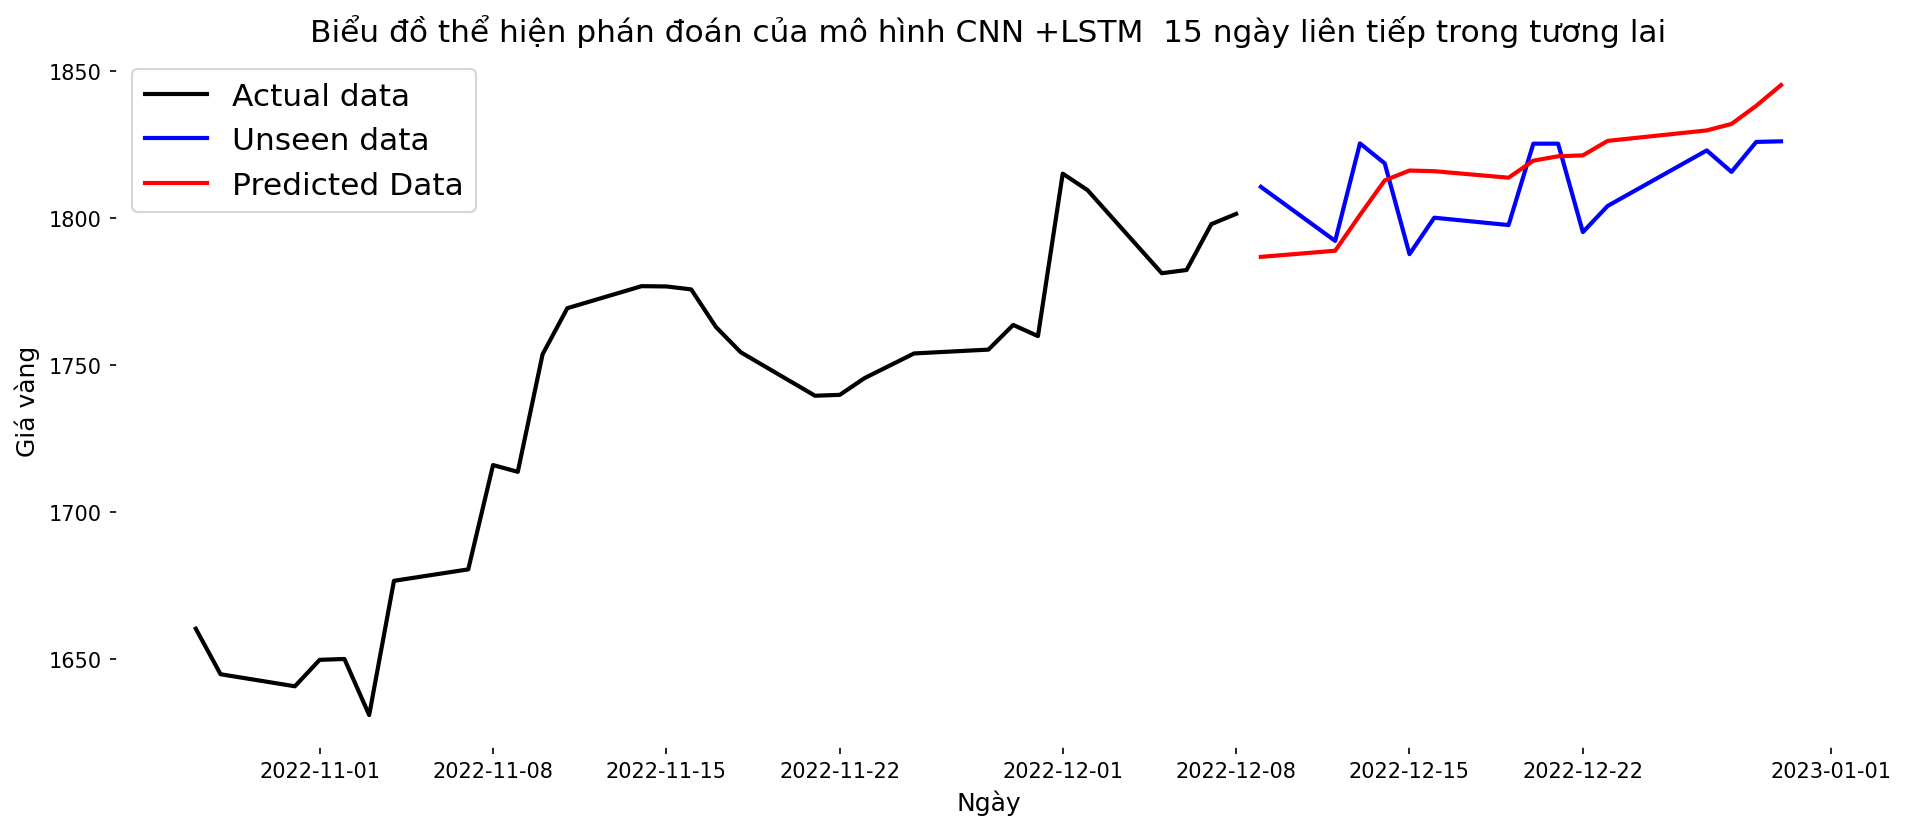

In [94]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[-(look_back + n_steps): -n_steps], df['Price'].iloc[-(look_back + n_steps): -n_steps], color='black', lw=2)
plt.plot(df['Date'].iloc[-n_steps:], df['Price'].iloc[-n_steps:], color='blue', lw=2)
plt.plot(df['Date'].iloc[-n_steps:], n_steps_prediction_model9.T[0], color='red', lw=2)
plt.title(f'Biểu đồ thể hiện phán đoán của mô hình CNN +LSTM  {n_steps} ngày liên tiếp trong tương lai', fontsize=15)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá vàng', fontsize=12)
plt.legend(['Actual data', 'Unseen data', 'Predicted Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [95]:
print(f"Biên độ giao động của giá trị dự báo xung quanh giá trị thực tế là {((df['Price'].iloc[-n_steps:].values - n_steps_prediction_model9.T[0]) **2).mean()**(1/2)}")

Biên độ giao động của giá trị dự báo xung quanh giá trị thực tế là 17.4783511144046


### Bảng đánh giá các độ đo của 5 mô hình single step trên tập test

In [96]:
index_model = ['LSTM', 'GRU', 'BiLSTM', 'CNN', 'CNN+LSTM']
metric_df_one_step.index = index_model

In [97]:
metric_df_one_step

,R2,MSE,RMSE,MAE,MAPE
LSTM,0.847014,1278.134051,35.751001,27.114725,0.014901
GRU,0.947518,438.463180,20.939512,16.222355,0.008951
BiLSTM,0.913992,718.556326,26.805901,20.558477,0.011438
CNN,0.780254,1835.883997,42.847217,35.344341,0.019652
CNN+LSTM,0.677296,2696.050671,51.923508,42.301880,0.023741


## 3. Multi Step Forecasting
- Từ n_steps_in dự đoán n_steps_out tương lai (VD: Từ 30 ngày trong quá khứ dự đoán 14 ngày tiếp theo)

In [98]:
class MultiStep:
    def __init__(self, data, n_steps_in, n_steps_out):
        """
        Khởi tạo dữ liệu từ data truyền vào và biến đổi dữ liệu
        
        Tham số:
            data: dữ liệu truyền vào
            n_steps_in: Số lượng quan sát thời gian cho mỗi chuỗi đầu vào
            n_steps_out: Số lượng quan sát thời gian cho mỗi chuỗi đầu ra
        """
        self.df = data.copy()
        self.n_steps_in = n_steps_in
        self.n_steps_out = n_steps_out
        self.n_columns = self.df.shape[1]
        
        self.scaler = StandardScaler()
        self.normalized_data = self.scaler.fit_transform(self.df.values)

    def data_mapping(self):
        """
        Từ dữ liệu đầu vào 2D array biến đổi thành các chuỗi quan sát thời gian với mỗi chuỗi input gồm n_steps_in quan sát thời gian
        và mỗi chuỗi output gồm n_steps_out quan sát thời gian
        Chuỗi chia với sải bước là 1
        
        Trả về:
            X: 3D array chuỗi input
            y: 3D array chuỗi output
        """
        num_samples = len(self.normalized_data) - self.n_steps_in - self.n_steps_out + 1
        
        X = np.empty((num_samples, self.n_steps_in, self.n_columns))
        y = np.empty((num_samples, self.n_steps_out, self.n_columns))

        for i in range(num_samples):
            X[i, :, :] = self.normalized_data[i:i + self.n_steps_in, :]
            y[i, :, :] = self.normalized_data[i + self.n_steps_in:i + self.n_steps_in + self.n_steps_out, :]

        return X, y

    def train_test_split(self, X, y, test_size):
        """
        Chia dữ liệu đã được ánh xạ sang các chuỗi thành tập train và test
        
        Tham số:
            X: input
            y: output
            test_size: Kích thước tập test
        
        Trả về:
            X_train, X_test, y_train, y_test
        """
        X_train, y_train = X[:-test_size], y[:-test_size]
        X_test, y_test = X[-test_size:], y[-test_size:]

        return X_train, X_test, y_train, y_test

    def multi_step_forecast(self, model, data: pd.DataFrame, iterations=1):
        """
        Dự đoán nhiều điểm dữ liệu tiếp theo bằng cách từ model dự đoán n_step_out. Bỏ dữ liệu ban đầu từ chuỗi n_steps_in sau đó đưa dữ liệu vừa dự đoán
        vào cuối của chuỗi n_steps_in để dự đoán tiếp theo. Lặp lại cho đến khi dự đoán được đủ iterations
    
        Tham số:
            model: Mô hình để dự đoán.
            data: 1 chuỗi n_steps_in bất kì để phán đoán n_step_out tiếp theo
            iterations: Số lần n_steps_out
    
        Trả về:
            np.array: 1 tập n_forecast_steps đã dự đoán.
        """
        # Scaling dữ liệu của chuỗi look back. last_steps shape = (self.n_steps_in, self.n_columns)
        last_steps = self.scaler.transform(data.values)
    
        # Định nghĩa 1 mẫu dữ liệu để dữ đoán output với shape = (n_forecast_steps, self.look_back, self.n_columns) để có thể fit từng mẫu vào mô hình dự đoán ra output
        normalized_data_mapped = np.empty((iterations, self.n_steps_in, self.n_columns))
    
        # Khởi tạo tập dự đoán chứa n_forecast_steps dự đoán từ mô hình
        predictions = np.empty((iterations, self.n_steps_out * self.n_columns))
    
        # Dự đoán trước 1 step
        normalized_data_mapped[0, :, :] = last_steps
        predictions[0, :] = model.predict(
            normalized_data_mapped[0, :, :].reshape(1, self.n_steps_in, self.n_columns),
            verbose=False
        )
        
        # Tạo ra n_forecast_steps dự đoán mới từ look back và 1 step đã dự đoán
        for i in range(1, iterations):
            # Loại bỏ quan sát ở đầu ra và thêm phán đoán mới vào chuỗi
            normalized_data_mapped[i, :-self.n_steps_out, :] = normalized_data_mapped[i - 1, self.n_steps_out:, :]
            normalized_data_mapped[i, -self.n_steps_out:, :] = predictions[i - 1, :].reshape(self.n_steps_out, self.n_columns)
    
            # Dự đoán quan sát tiếp theo
            norm_data = normalized_data_mapped[i, :, :].reshape(1, self.n_steps_in, self.n_columns)
            predictions[i, :] = model.predict(norm_data, verbose=False)
    
        # Inverse dữ liệu 
        predictions = predictions.reshape(-1, self.n_steps_out, self.n_columns)
        
        forecast_data = []
        
        for i in range(iterations):
            predictions[i] = self.scaler.inverse_transform(predictions[i])
            forecast_data += list(predictions[i].T[0])
        
        return forecast_data

- Các đặc trưng sử dụng

In [99]:
columns = ['Price', 'Open', 'Low', 'High', 'Vol.']

- Lựa chọn 90 quan sát thời gian dự đoán 15 quan sát thời gian

In [100]:
n_steps_in = 90
n_steps_out = 10

In [101]:
# Đưa dữ liệu vào để biến đổi 
msp_data_model = MultiStep(df[columns], n_steps_in, n_steps_out)

# data đã được scaled và biến đổi theo 90 ngày dự đoán 14 ngày
X, y = msp_data_model.data_mapping()

In [102]:
X.shape, y.shape

((2479, 90, 5), (2479, 10, 5))

In [103]:
X_train, X_test, y_train, y_test = msp_data_model.train_test_split(X, y, TEST_SIZE)

In [104]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2223, 90, 5), (256, 90, 5), (2223, 10, 5), (256, 10, 5))

#### 3.1. Dự đoán multistep bằng mô hình LSTM

In [105]:
def lstm_multi_step_model():
    input = Input(shape=X_train[0].shape)
    x = LSTM(units=128, return_sequences=False)(input)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(n_steps_out*len(columns))(x)

    model = Model(inputs=input, outputs=[output])
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    
    return model

In [106]:
model5 = lstm_multi_step_model()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 90, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 128)            │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 50)             │         3,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,114 (312.95 KB)

 Trainable params: 80,114 (312.95 KB)

 Non-trainable params: 0 (0.00 B)

In [107]:
model_checkpoint5 = ModelCheckpoint(filepath='model5.keras', save_best_only=True, monitor='val_loss')

In [108]:
history5 = model5.fit(X_train, 
                      y_train.reshape(-1, n_steps_out*len(columns)), 
                      epochs=25, 
                      batch_size=128, 
                      validation_data=(X_test, y_test.reshape(-1, n_steps_out*len(columns))), 
                      verbose=False,
                      callbacks=[model_checkpoint5])

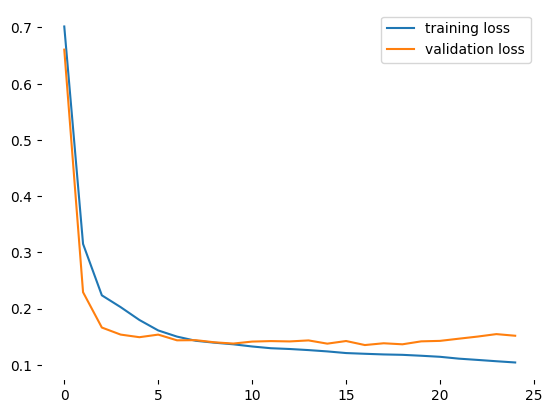

In [109]:
plt.plot(history5.history['loss'], label = 'training loss')
plt.plot(history5.history['val_loss'], label ='validation loss')
plt.legend()
plt.show()

In [110]:
model5 = models.load_model('model5.keras')

In [111]:
result5 = model5.evaluate(X_test, y_test.reshape(-1, n_steps_out*len(columns)))
y_test_pred_model5 = model5.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1164  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


- Lấy ra giá vàng của tập test để đánh giá

In [112]:
y_test_pred_model5 = y_test_pred_model5.reshape(-1, n_steps_out, len(columns))
iterations = TEST_SIZE // n_steps_out + 1
remain = TEST_SIZE % n_steps_out

y_price_test_pred_model5 = []

for i in range(iterations):
    y_price_test_pred_model5 += list(msp_data_model.scaler.inverse_transform(y_test_pred_model5[i*n_steps_out]).T[0])
    
if remain != 0:
    y_price_test_pred_model5 += list(msp_data_model.scaler.inverse_transform(y_test_pred_model5[-1]).T[0][-remain+1:])

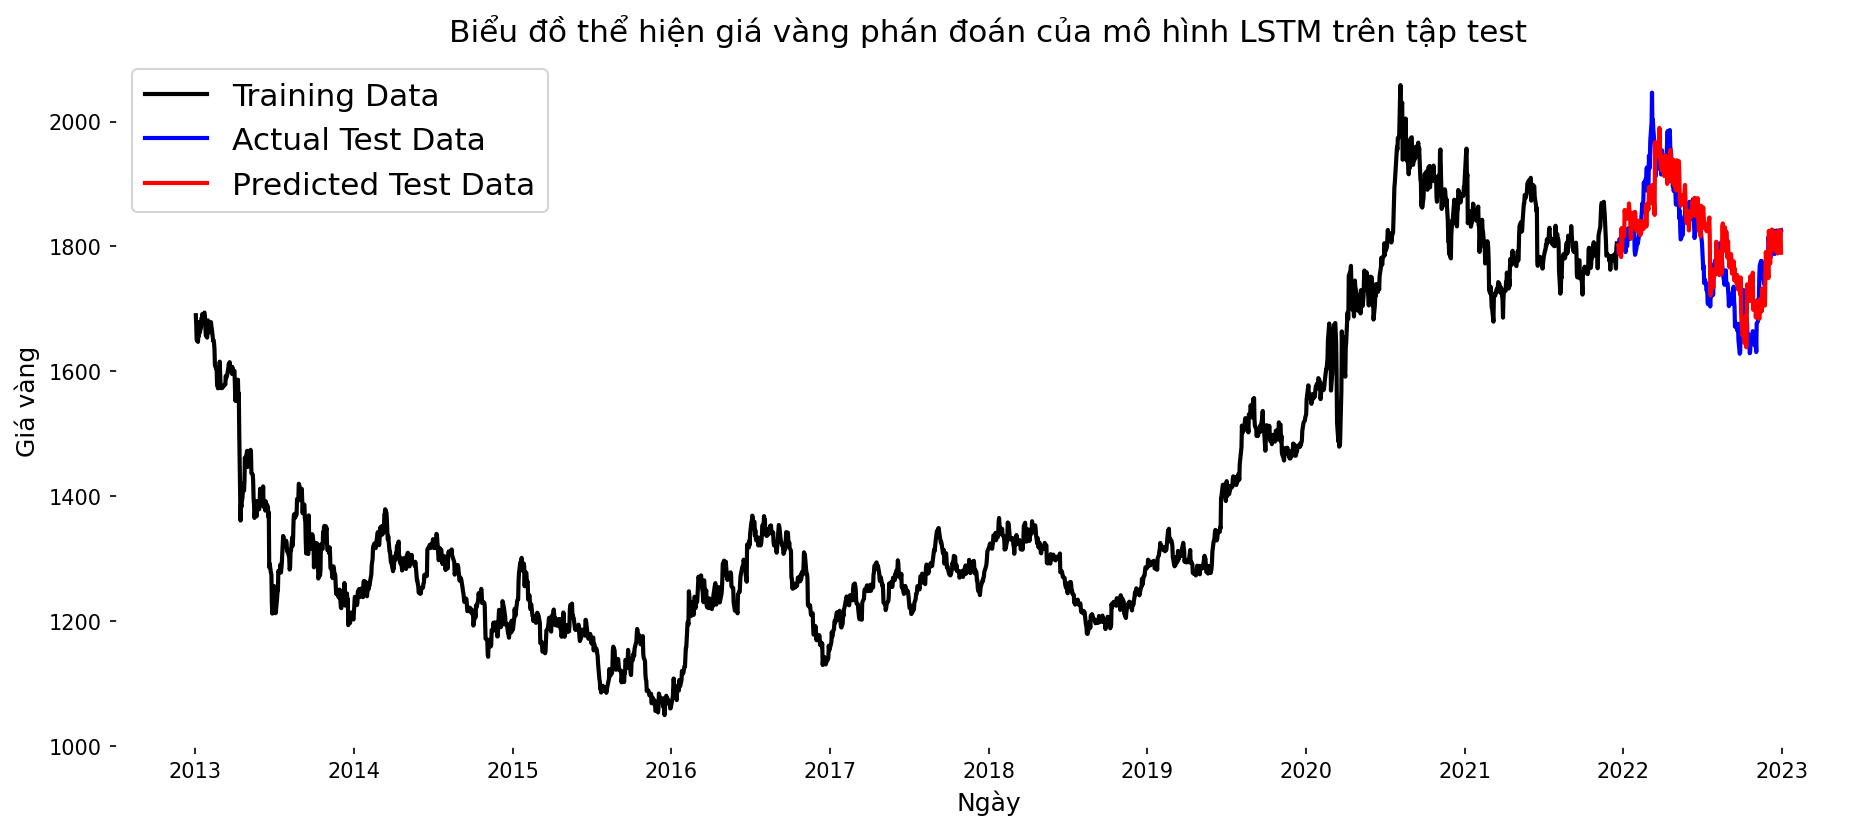

In [113]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-(TEST_SIZE+n_steps_out-1)], df['Price'].iloc[:-(TEST_SIZE+n_steps_out-1)], color='black', lw=2)
plt.plot(df['Date'].iloc[-(TEST_SIZE+n_steps_out-1):], df['Price'].iloc[-(TEST_SIZE+n_steps_out-1):], color='blue', lw=2)
plt.plot(df['Date'].iloc[-(TEST_SIZE+n_steps_out-1):], y_price_test_pred_model5, color='red', lw=2)
plt.title('Biểu đồ thể hiện giá vàng phán đoán của mô hình LSTM trên tập test', fontsize=15)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá vàng', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [114]:
print('MAPE: {}'.format(mean_absolute_percentage_error(df['Price'].iloc[-(TEST_SIZE+n_steps_out-1):].values, y_price_test_pred_model5)))
print('Accuracy: {}'.format((1 - mean_absolute_percentage_error(df['Price'].iloc[-(TEST_SIZE+n_steps_out-1):].values, y_price_test_pred_model5))*100))

MAPE: 0.02245104144407755
Accuracy: 97.75489585559225


In [115]:
metric_df_multi_steps.loc[len(metric_df_multi_steps.index)] = measure_metric(df['Price'].iloc[-(TEST_SIZE+n_steps_out-1):].values, y_price_test_pred_model5)

R2: 0.6775542883889745
MSE: 2603.825549685613
RMSE: 51.02769394834155
MAE: 40.0072243514151
MAPE: 0.02245104144407755


- Dự đoán 30 quan sát thời gian trong tương lai

In [116]:
n_iters = 3
n_steps_data = df[columns].iloc[-(n_steps_in + n_steps_out * n_iters): -(n_steps_out * n_iters), :]
n_steps_prediction_model5 = msp_data_model.multi_step_forecast(model5, n_steps_data, n_iters)

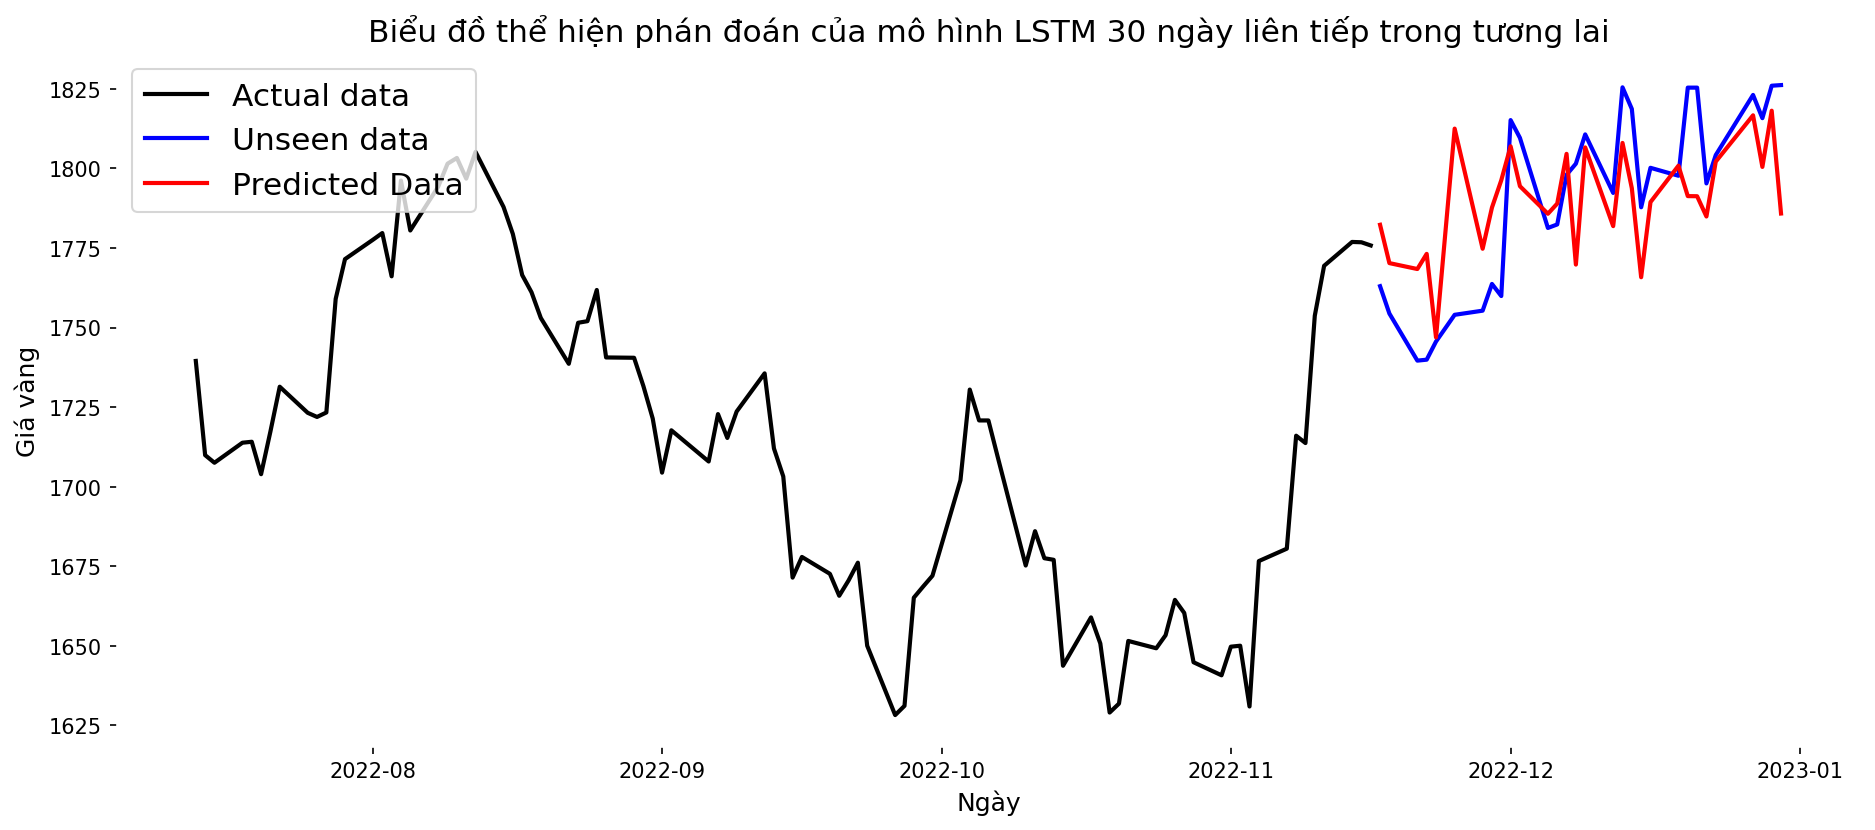

In [117]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[-(n_steps_in + n_steps_out * n_iters): -(n_steps_out * n_iters)], df['Price'].iloc[-(n_steps_in + n_steps_out * n_iters): -(n_steps_out * n_iters)], color='black', lw=2)
plt.plot(df['Date'].iloc[-(n_steps_out * n_iters):], df['Price'].iloc[-(n_steps_out * n_iters):], color='blue', lw=2)
plt.plot(df['Date'].iloc[-(n_steps_out * n_iters):], n_steps_prediction_model5, color='red', lw=2)
plt.title(f'Biểu đồ thể hiện phán đoán của mô hình LSTM {n_steps_out * n_iters} ngày liên tiếp trong tương lai', fontsize=15)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá vàng', fontsize=12)
plt.legend(['Actual data', 'Unseen data', 'Predicted Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [118]:
print(f"Biên độ dao động của giá trị dự báo xung quanh giá trị thực tế là {((df['Price'].iloc[-(n_steps_out * n_iters):].values - n_steps_prediction_model5) **2).mean()**(1/2)}")

Biên độ dao động của giá trị dự báo xung quanh giá trị thực tế là 22.907100267713645


#### 3.2. Dự đoán multistep bằng mô hình GRU


In [119]:
def gru_multi_step_model():
    input = Input(shape=X_train[0].shape)
    x = GRU(units=128, return_sequences=False)(input)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(n_steps_out*len(columns))(x)

    model = Model(inputs=input, outputs=[output])
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    
    return model

In [120]:
model6 = gru_multi_step_model()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 90, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 128)            │        51,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 50)             │         3,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,346 (247.45 KB)

 Trainable params: 63,346 (247.45 KB)

 Non-trainable params: 0 (0.00 B)

In [121]:
model_checkpoint6 = ModelCheckpoint(filepath='model6.keras', monitor='val_loss', save_best_only=True)

In [122]:
history6 = model6.fit(X_train, y_train.reshape(-1, n_steps_out * len(columns)), 
                      epochs=25, 
                      batch_size=128, 
                      validation_data=(X_test, y_test.reshape(-1, n_steps_out * len(columns))), 
                      callbacks=[model_checkpoint6],
                      verbose=False)

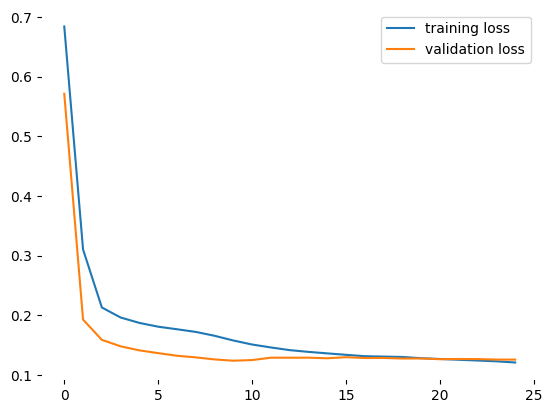

In [123]:
plt.plot(history6.history['loss'], label = 'training loss')
plt.plot(history6.history['val_loss'], label ='validation loss')
plt.legend()
plt.show()

In [124]:
model6 = models.load_model('model6.keras')

In [125]:
result6 = model6.evaluate(X_test, y_test.reshape(-1, n_steps_out*len(columns)))
y_test_pred_model6 = model6.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1330  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [126]:
y_test_pred_model6 = y_test_pred_model6.reshape(-1, n_steps_out, len(columns))
iterations = TEST_SIZE // n_steps_out + 1
remain = TEST_SIZE % n_steps_out

y_price_test_pred_model6 = []

for i in range(iterations):
    y_price_test_pred_model6 += list(msp_data_model.scaler.inverse_transform(y_test_pred_model6[i*n_steps_out]).T[0])
    
if remain != 0:
    y_price_test_pred_model6 += list(msp_data_model.scaler.inverse_transform(y_test_pred_model6[-1]).T[0][-remain+1:])

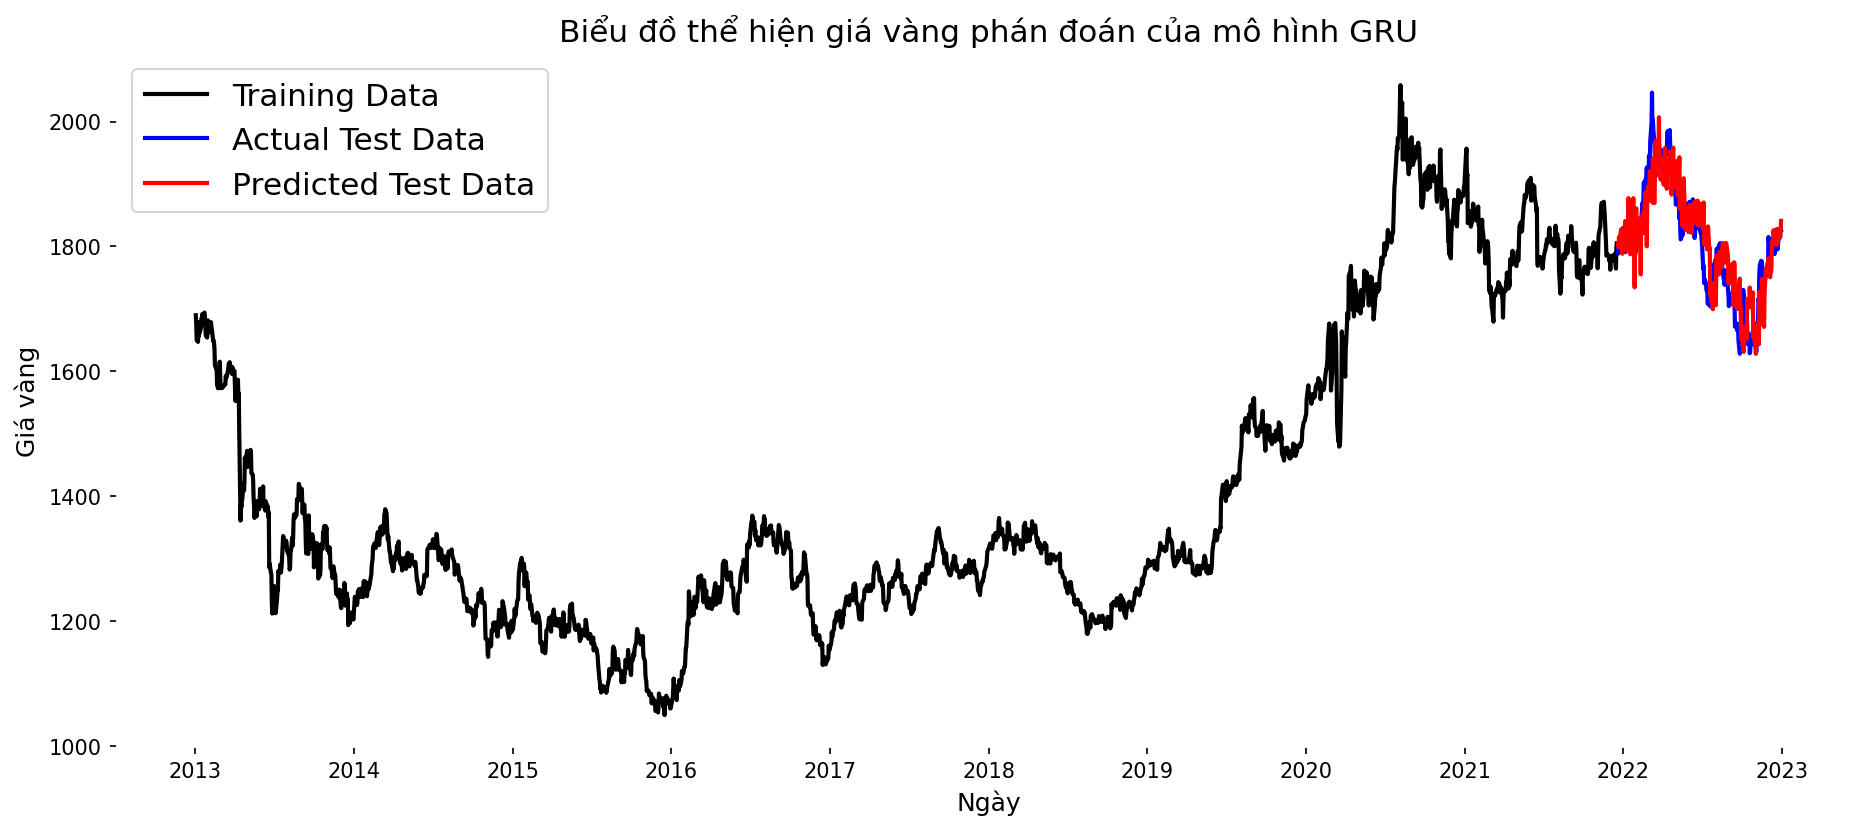

In [127]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-(TEST_SIZE+n_steps_out-1)], df['Price'].iloc[:-(TEST_SIZE+n_steps_out-1)], color='black', lw=2)
plt.plot(df['Date'].iloc[-(TEST_SIZE+n_steps_out-1):], df['Price'].iloc[-(TEST_SIZE+n_steps_out-1):], color='blue', lw=2)
plt.plot(df['Date'].iloc[-(TEST_SIZE+n_steps_out-1):], y_price_test_pred_model6, color='red', lw=2)
plt.title('Biểu đồ thể hiện giá vàng phán đoán của mô hình GRU', fontsize=15)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá vàng', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [128]:
print('MAPE: {}'.format(mean_absolute_percentage_error(df['Price'].iloc[-(TEST_SIZE+n_steps_out-1):].values, y_price_test_pred_model6)))
print('Accuracy: {}'.format((1 - mean_absolute_percentage_error(df['Price'].iloc[-(TEST_SIZE+n_steps_out-1):].values, y_price_test_pred_model6))*100))

MAPE: 0.019341815578957058
Accuracy: 98.06581844210429


In [129]:
metric_df_multi_steps.loc[len(metric_df_multi_steps.index)] = measure_metric(df['Price'].iloc[-(TEST_SIZE+n_steps_out-1):].values, y_price_test_pred_model6)

R2: 0.7465995251484543
MSE: 2046.2688972488731
RMSE: 45.23570378858798
MAE: 34.680997659935144
MAPE: 0.019341815578957058


In [130]:
n_steps_prediction_model6 = msp_data_model.multi_step_forecast(model6, n_steps_data, n_iters)

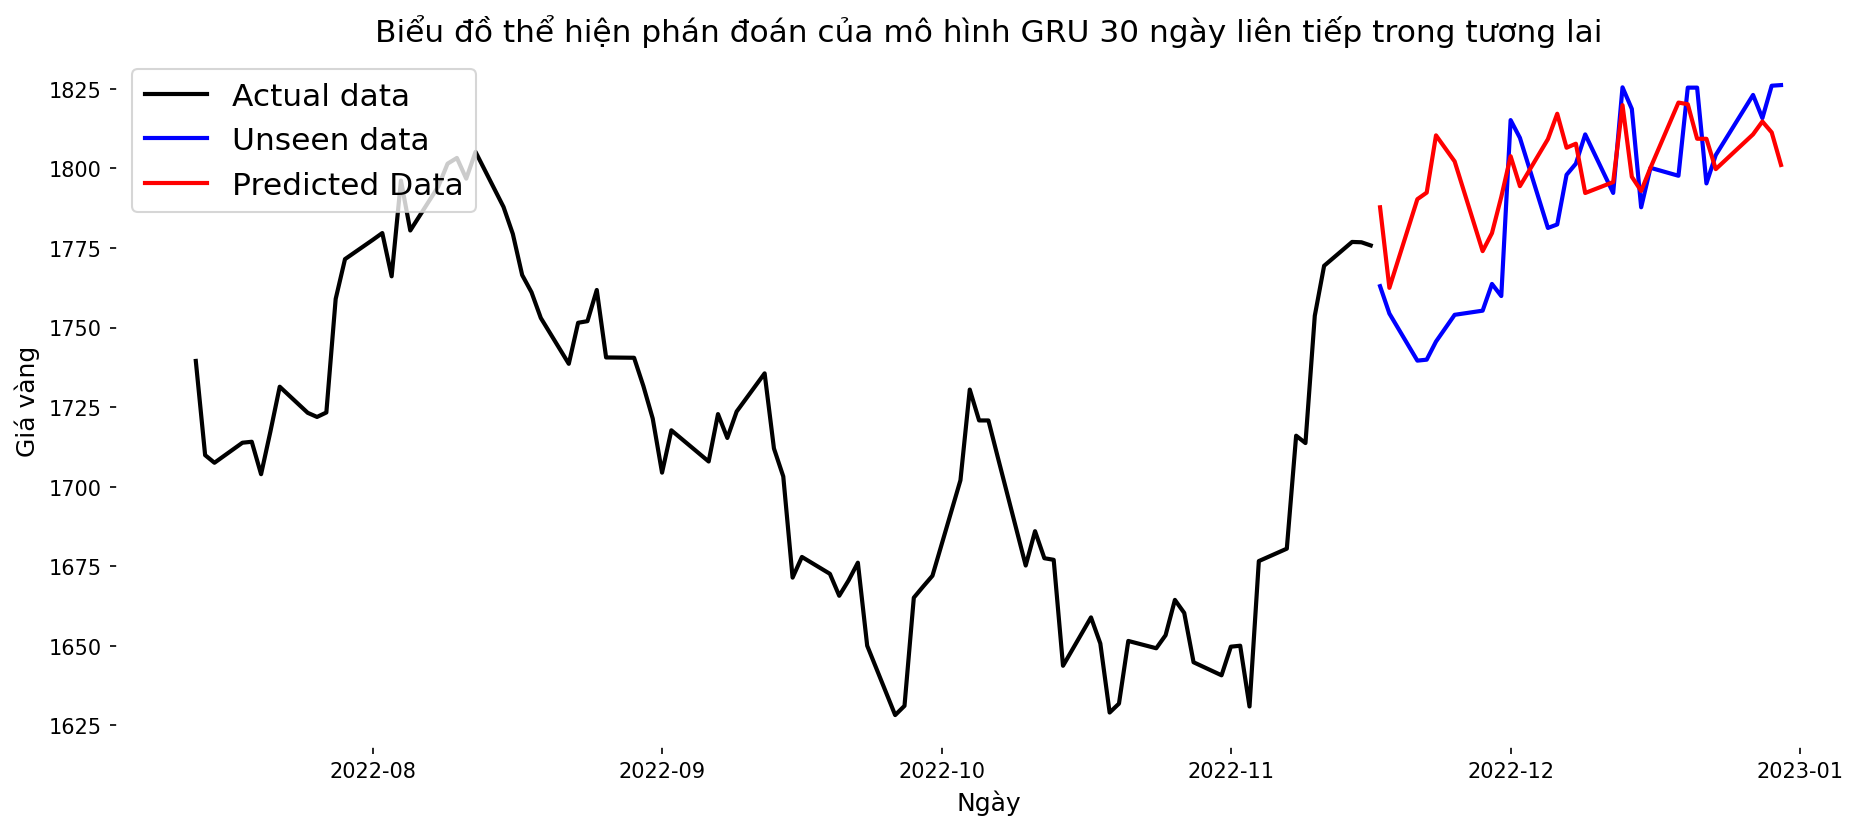

In [131]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[-(n_steps_in + n_steps_out * n_iters): -(n_steps_out * n_iters)], df['Price'].iloc[-(n_steps_in + n_steps_out * n_iters): -(n_steps_out * n_iters)], color='black', lw=2)
plt.plot(df['Date'].iloc[-(n_steps_out * n_iters):], df['Price'].iloc[-(n_steps_out * n_iters):], color='blue', lw=2)
plt.plot(df['Date'].iloc[-(n_steps_out * n_iters):], n_steps_prediction_model6, color='red', lw=2)
plt.title(f'Biểu đồ thể hiện phán đoán của mô hình GRU {n_steps_out * n_iters} ngày liên tiếp trong tương lai', fontsize=15)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá vàng', fontsize=12)
plt.legend(['Actual data', 'Unseen data', 'Predicted Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [132]:
print(f"Biên độ giao động của giá trị dự báo xung quanh giá trị thực tế là {((df['Price'].iloc[-(n_steps_out * n_iters):].values - n_steps_prediction_model6) **2).mean()**(1/2)}")

Biên độ giao động của giá trị dự báo xung quanh giá trị thực tế là 25.472031496663515


#### 3.3. Dự đoán multistep bằng mô hình BiLSTM

In [133]:
def bilstm_multi_step_model():
    input = Input(shape=X_train[0].shape)
    x = Bidirectional(LSTM(units=64, return_sequences=False))(input)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(n_steps_out*len(columns))(x)

    model = Model(inputs=input, outputs=[output])
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    
    return model

In [134]:
model7 = bilstm_multi_step_model()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 90, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        35,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 50)             │         3,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,346 (184.95 KB)

 Trainable params: 47,346 (184.95 KB)

 Non-trainable params: 0 (0.00 B)

In [135]:
model_checkpoint7 = ModelCheckpoint(filepath='model7.keras', monitor='val_loss', save_best_only=True)

In [136]:
history7 = model7.fit(X_train, y_train.reshape(-1, n_steps_out * len(columns)), 
                      epochs=25, 
                      batch_size=128, 
                      validation_data=(X_test, y_test.reshape(-1, n_steps_out * len(columns))), 
                      verbose=False,
                      callbacks=[model_checkpoint7])

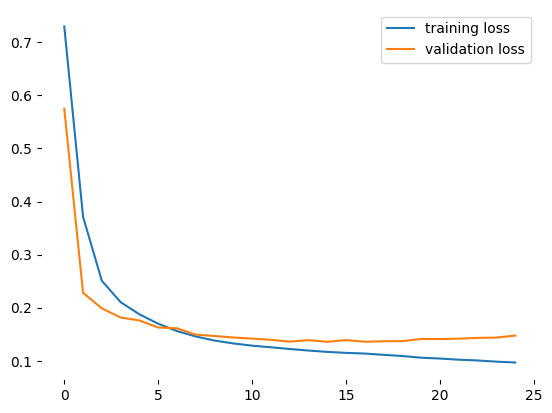

In [137]:
plt.plot(history7.history['loss'], label = 'training loss')
plt.plot(history7.history['val_loss'], label ='validation loss')
plt.legend()
plt.show()

In [138]:
model7 = models.load_model('model7.keras')

In [139]:
result7 = model7.evaluate(X_test, y_test.reshape(-1, n_steps_out*len(columns)))
y_test_pred_model7 = model7.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1150  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


In [140]:
y_test_pred_model7 = y_test_pred_model7.reshape(-1, n_steps_out, len(columns))
iterations = TEST_SIZE // n_steps_out + 1
remain = TEST_SIZE % n_steps_out

y_price_test_pred_model7 = []

for i in range(iterations):
    y_price_test_pred_model7 += list(msp_data_model.scaler.inverse_transform(y_test_pred_model7[i*n_steps_out]).T[0])
    
if remain != 0:
    y_price_test_pred_model7 += list(msp_data_model.scaler.inverse_transform(y_test_pred_model7[-1]).T[0][-remain+1:])

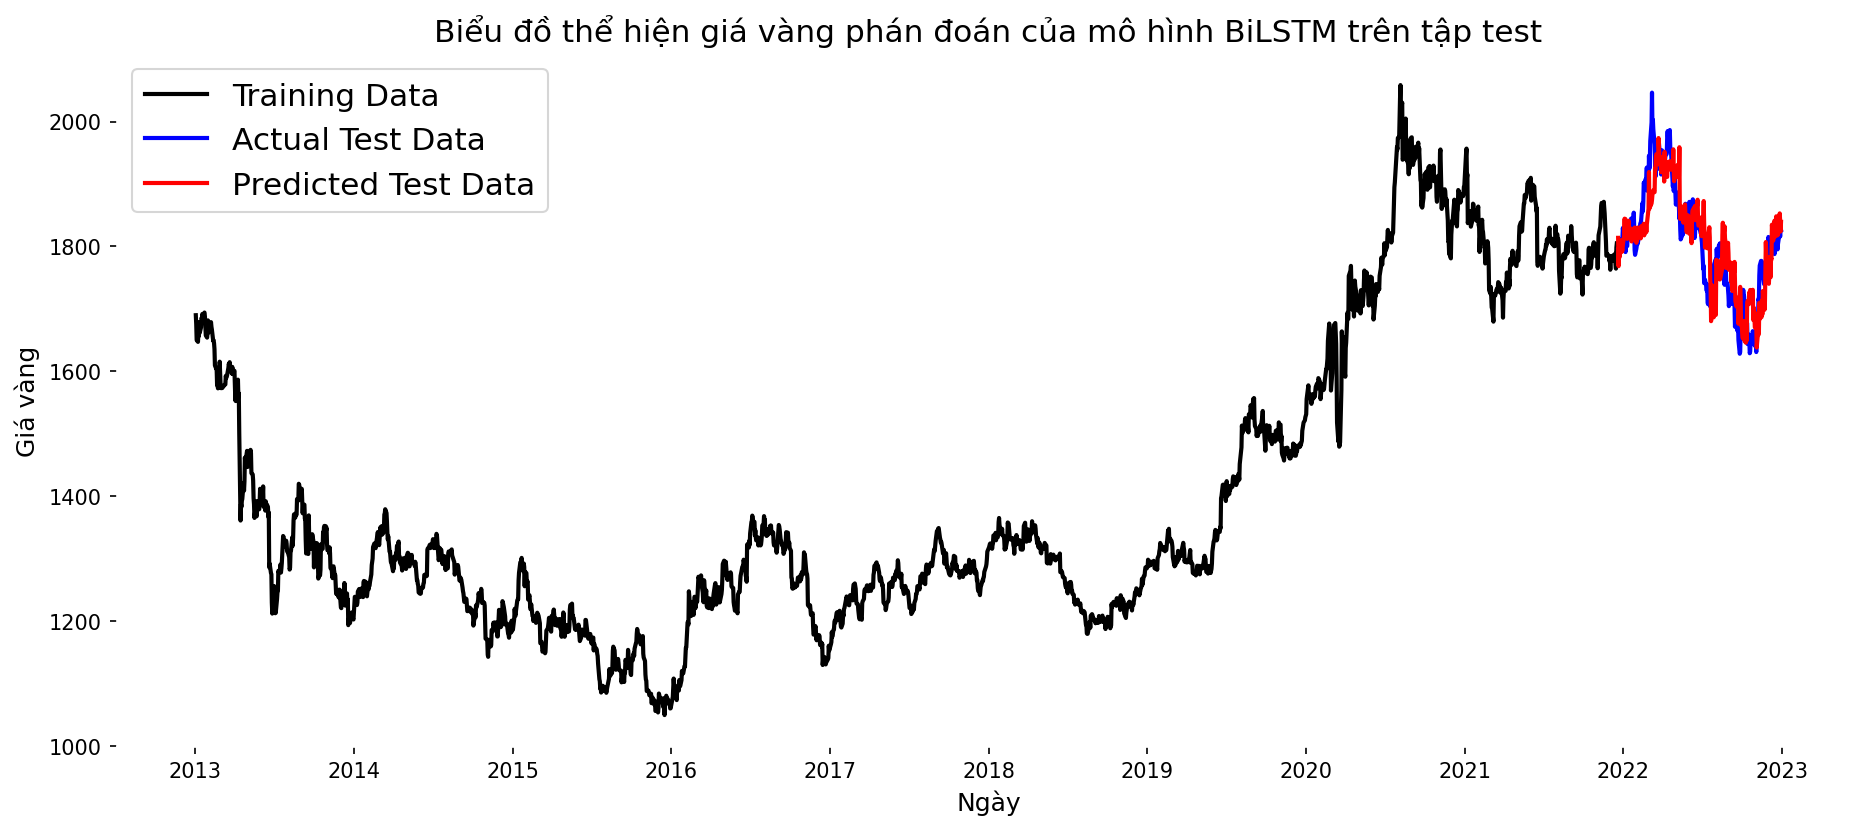

In [141]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-(TEST_SIZE+n_steps_out-1)], df['Price'].iloc[:-(TEST_SIZE+n_steps_out-1)], color='black', lw=2)
plt.plot(df['Date'].iloc[-(TEST_SIZE+n_steps_out-1):], df['Price'].iloc[-(TEST_SIZE+n_steps_out-1):], color='blue', lw=2)
plt.plot(df['Date'].iloc[-(TEST_SIZE+n_steps_out-1):], y_price_test_pred_model7, color='red', lw=2)
plt.title('Biểu đồ thể hiện giá vàng phán đoán của mô hình BiLSTM trên tập test', fontsize=15)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá vàng', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [142]:
print('MAPE: {}'.format(mean_absolute_percentage_error(df['Price'].iloc[-(TEST_SIZE+n_steps_out-1):].values, y_price_test_pred_model7)))
print('Accuracy: {}'.format((1 - mean_absolute_percentage_error(df['Price'].iloc[-(TEST_SIZE+n_steps_out-1):].values, y_price_test_pred_model7))*100))

MAPE: 0.021348293797315728
Accuracy: 97.86517062026843


In [143]:
metric_df_multi_steps.loc[len(metric_df_multi_steps.index)] = measure_metric(df['Price'].iloc[-(TEST_SIZE+n_steps_out-1):].values, y_price_test_pred_model7)

R2: 0.7116637889777626
MSE: 2328.383247549361
RMSE: 48.253323694325566
MAE: 38.234738631338445
MAPE: 0.021348293797315728


In [144]:
n_steps_prediction_model7 = msp_data_model.multi_step_forecast(model7, n_steps_data, n_iters)

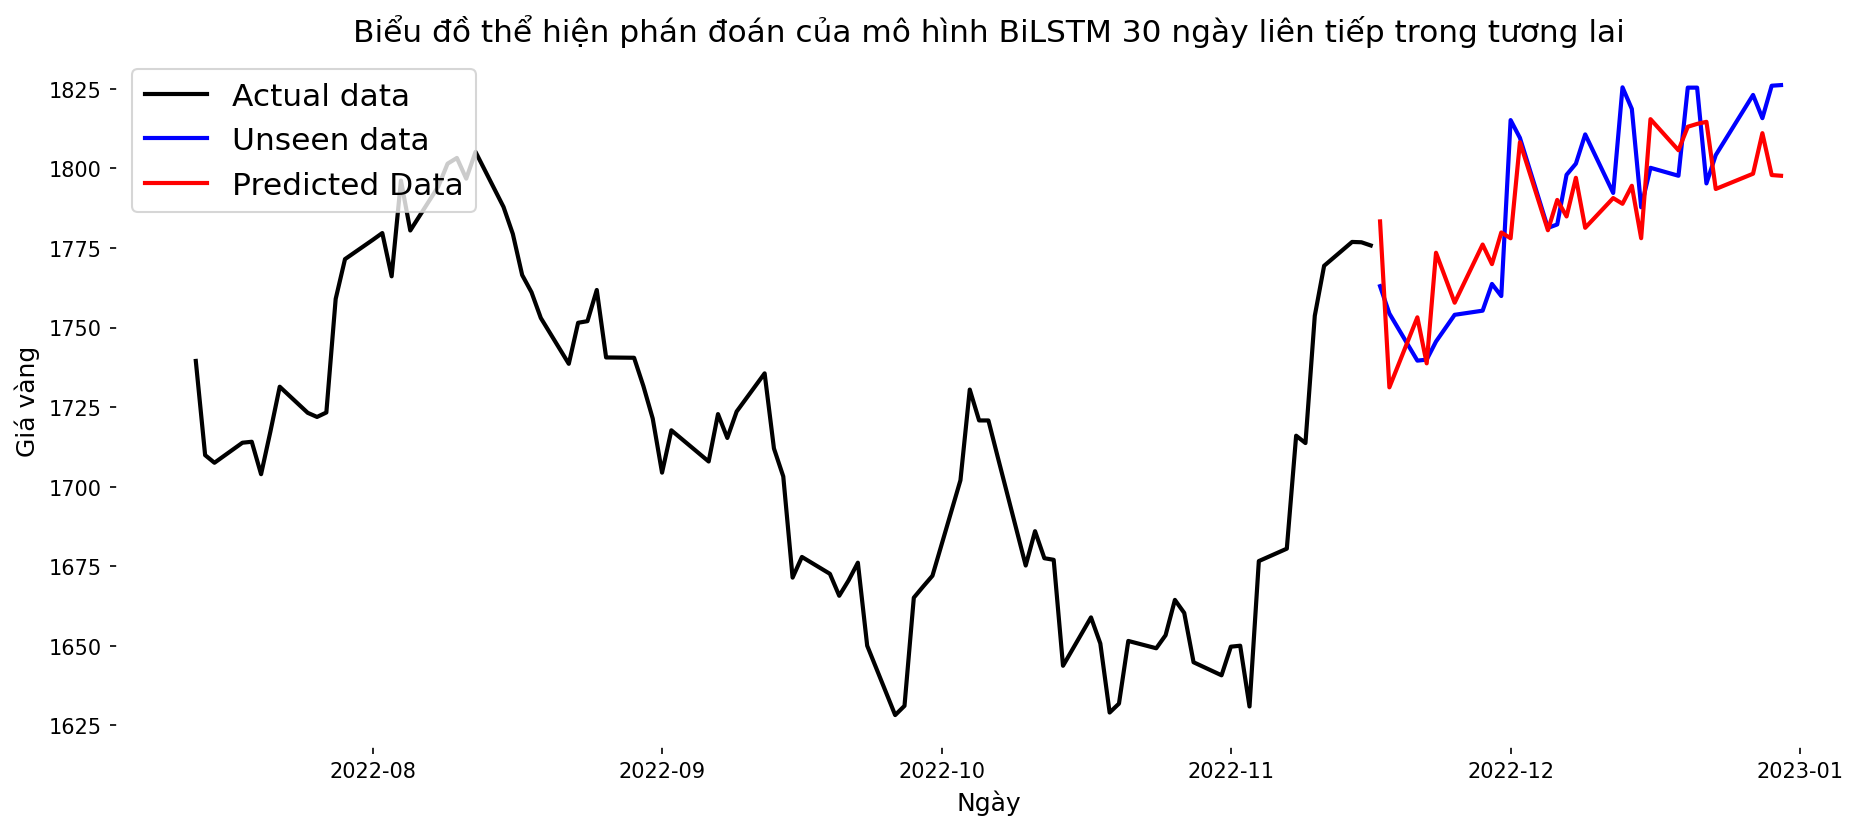

In [145]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[-(n_steps_in + n_steps_out * n_iters): -(n_steps_out * n_iters)], df['Price'].iloc[-(n_steps_in + n_steps_out * n_iters): -(n_steps_out * n_iters)], color='black', lw=2)
plt.plot(df['Date'].iloc[-(n_steps_out * n_iters):], df['Price'].iloc[-(n_steps_out * n_iters):], color='blue', lw=2)
plt.plot(df['Date'].iloc[-(n_steps_out * n_iters):], n_steps_prediction_model7, color='red', lw=2)
plt.title(f'Biểu đồ thể hiện phán đoán của mô hình BiLSTM {n_steps_out * n_iters} ngày liên tiếp trong tương lai', fontsize=15)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá vàng', fontsize=12)
plt.legend(['Actual data', 'Unseen data', 'Predicted Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [146]:
print(f"Biên độ giao động của giá trị dự báo xung quanh giá trị thực tế là {((df['Price'].iloc[-(n_steps_out * n_iters):].values - n_steps_prediction_model7) **2).mean()**(1/2)}")

Biên độ giao động của giá trị dự báo xung quanh giá trị thực tế là 18.81453540672331


#### 3.4. Dự đoán multistep bằng mô hình CNN

In [199]:
def cnn_multi_step_model():
    input = Input(shape=X_train[0].shape)
    x = Conv1D(filters=64, kernel_size=3)(input)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dropout(0.1)(x)
    x = Dense(units=64, activation='relu')(x)
    output = Dense(n_steps_out*len(columns))(x)
    
    model = Model(inputs=input, outputs=[output])
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    
    return model

In [200]:
model8 = cnn_multi_step_model()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 90, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 88, 64)         │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 44, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2816)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 2816)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │       180,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 50)             │         3,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,562 (720.95 KB)

 Trainable params: 184,562 (720.95 KB)

 Non-trainable params: 0 (0.00 B)

In [201]:
model_checkpoint8 = ModelCheckpoint(filepath='model8.keras', monitor='val_loss', save_best_only=True)

In [202]:
history8 = model8.fit(X_train, 
                      y_train.reshape(-1, n_steps_out*len(columns)), 
                      epochs=25, 
                      batch_size=128, 
                      validation_data=(X_test, y_test.reshape(-1, n_steps_out * len(columns))), 
                      verbose=False,
                      callbacks=[model_checkpoint8])

W0000 00:00:1718980503.668023     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718980505.318803     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718980505.660620     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


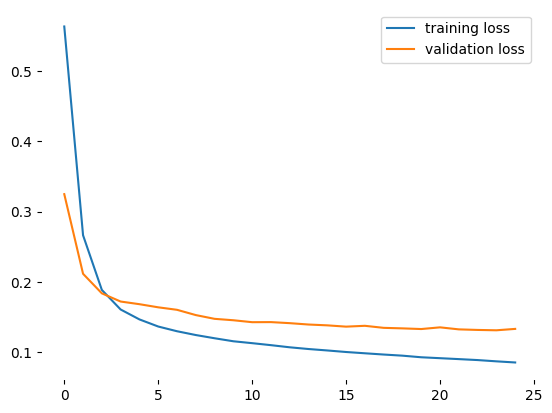

In [203]:
plt.plot(history8.history['loss'], label = 'training loss')
plt.plot(history8.history['val_loss'], label ='validation loss')
plt.legend()
plt.show()

In [204]:
model8 = models.load_model('model8.keras')

In [205]:
result8 = model8.evaluate(X_test, y_test.reshape(-1, n_steps_out*len(columns)))
y_test_pred_model8 = model8.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1082  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


In [206]:
y_test_pred_model8 = y_test_pred_model8.reshape(-1, n_steps_out, len(columns))
iterations = TEST_SIZE // n_steps_out + 1
remain = TEST_SIZE % n_steps_out

y_price_test_pred_model8 = []

for i in range(iterations):
    y_price_test_pred_model8 += list(msp_data_model.scaler.inverse_transform(y_test_pred_model8[i*n_steps_out]).T[0])
    
if remain != 0:
    y_price_test_pred_model8 += list(msp_data_model.scaler.inverse_transform(y_test_pred_model8[-1]).T[0][-remain+1:])

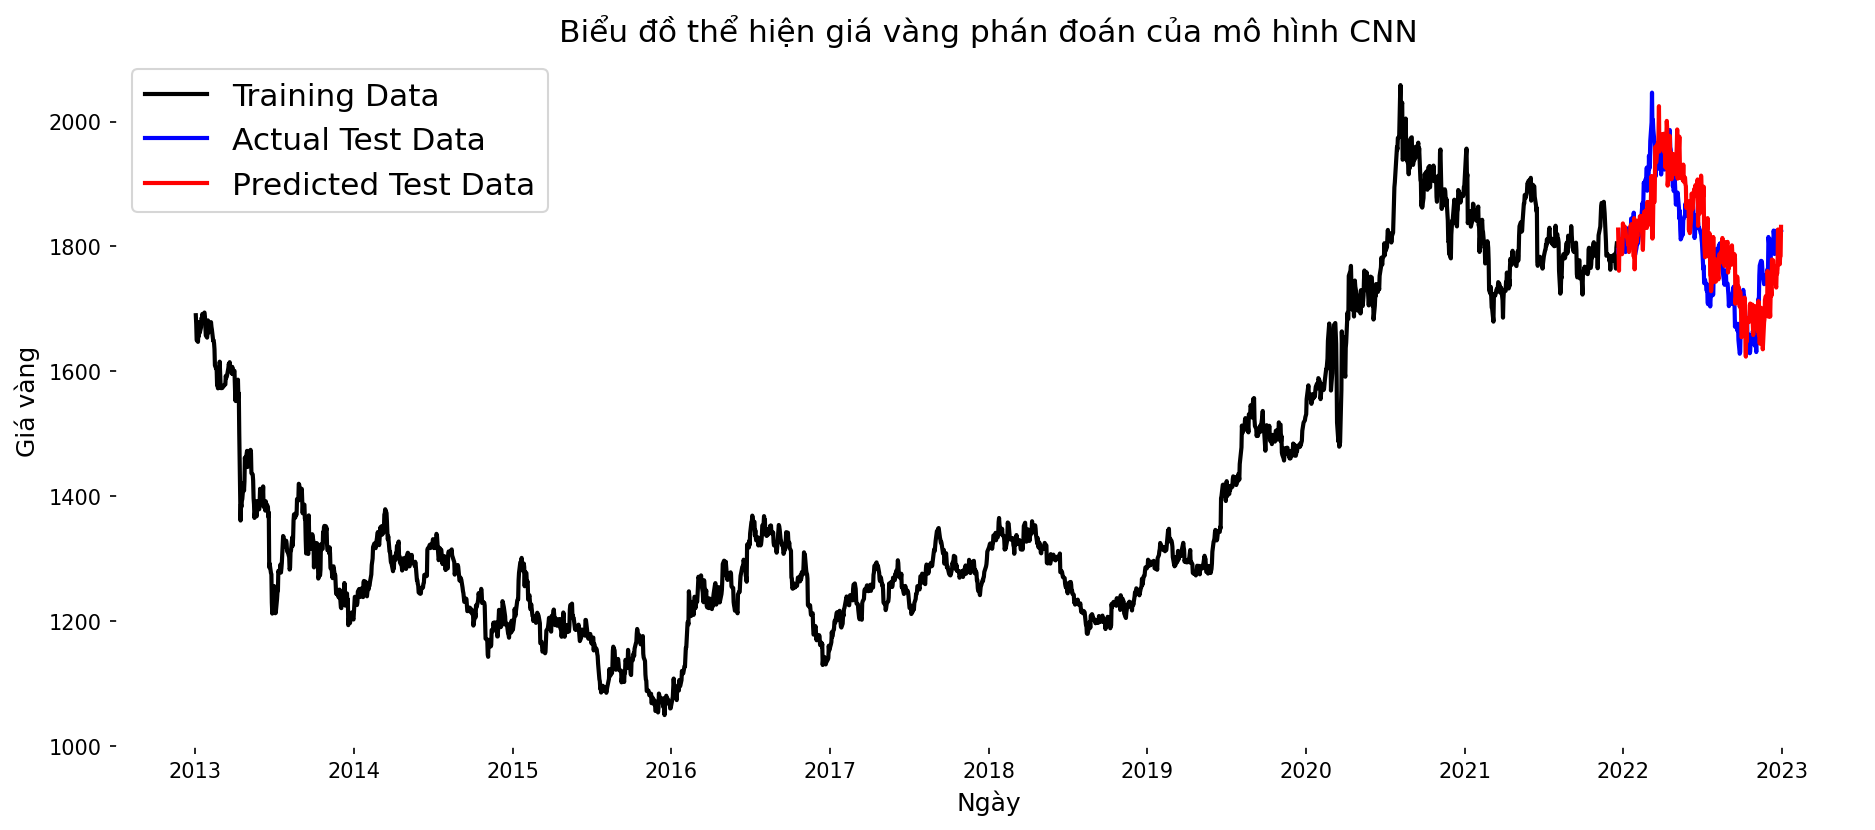

In [207]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-(TEST_SIZE+n_steps_out-1)], df['Price'].iloc[:-(TEST_SIZE+n_steps_out-1)], color='black', lw=2)
plt.plot(df['Date'].iloc[-(TEST_SIZE+n_steps_out-1):], df['Price'].iloc[-(TEST_SIZE+n_steps_out-1):], color='blue', lw=2)
plt.plot(df['Date'].iloc[-(TEST_SIZE+n_steps_out-1):], y_price_test_pred_model8, color='red', lw=2)
plt.title('Biểu đồ thể hiện giá vàng phán đoán của mô hình CNN', fontsize=15)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá vàng', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [208]:
print('MAPE: {}'.format(mean_absolute_percentage_error(df['Price'].iloc[-(TEST_SIZE+n_steps_out-1):].values, y_price_test_pred_model8)))
print('Accuracy: {}'.format((1 - mean_absolute_percentage_error(df['Price'].iloc[-(TEST_SIZE+n_steps_out-1):].values, y_price_test_pred_model8))*100))

MAPE: 0.026170692602146325
Accuracy: 97.38293073978537


In [157]:
metric_df_multi_steps.loc[len(metric_df_multi_steps.index)] = measure_metric(df['Price'].iloc[-(TEST_SIZE+n_steps_out-1):].values, y_price_test_pred_model8)

R2: 0.514699151663449
MSE: 3918.919379852612
RMSE: 62.60127298907437
MAE: 50.93962089106722
MAPE: 0.028239721373682823


In [209]:
n_steps_prediction_model8 = msp_data_model.multi_step_forecast(model8, n_steps_data, n_iters)

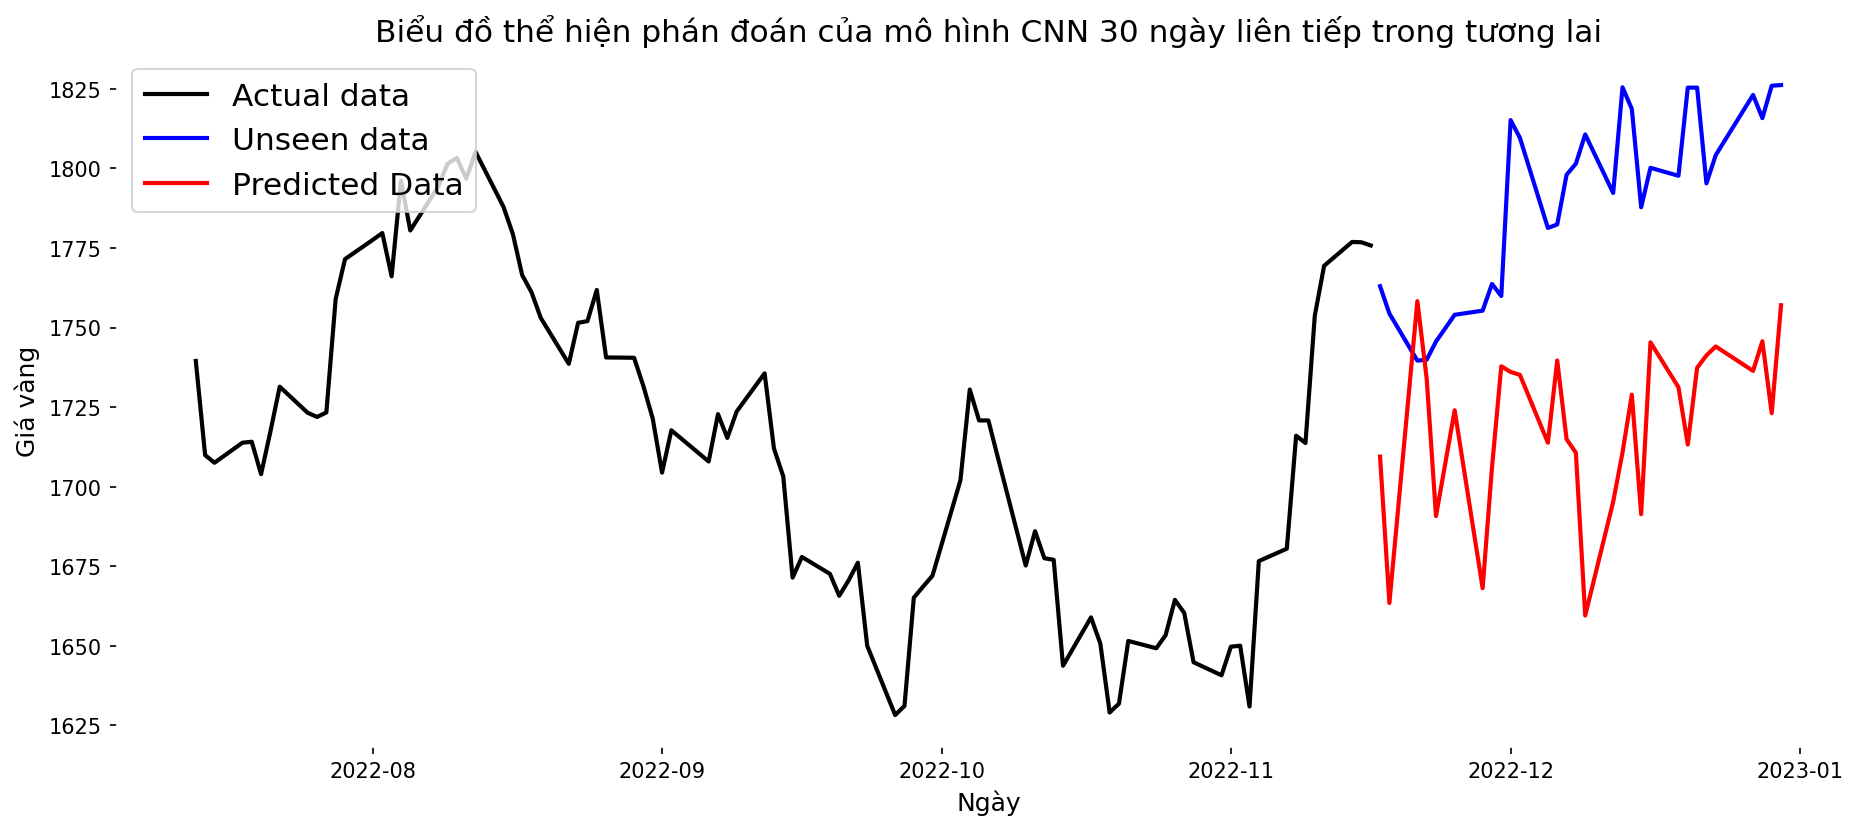

In [210]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[-(n_steps_in + n_steps_out * n_iters): -(n_steps_out * n_iters)], df['Price'].iloc[-(n_steps_in + n_steps_out * n_iters): -(n_steps_out * n_iters)], color='black', lw=2)
plt.plot(df['Date'].iloc[-(n_steps_out * n_iters):], df['Price'].iloc[-(n_steps_out * n_iters):], color='blue', lw=2)
plt.plot(df['Date'].iloc[-(n_steps_out * n_iters):], n_steps_prediction_model8, color='red', lw=2)
plt.title(f'Biểu đồ thể hiện phán đoán của mô hình CNN {n_steps_out * n_iters} ngày liên tiếp trong tương lai', fontsize=15)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá vàng', fontsize=12)
plt.legend(['Actual data', 'Unseen data', 'Predicted Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [211]:
print(f"Biên độ giao động của giá trị dự báo xung quanh giá trị thực tế là {((df['Price'].iloc[-(n_steps_out * n_iters):].values - n_steps_prediction_model8) **2).mean()**(1/2)}")

Biên độ giao động của giá trị dự báo xung quanh giá trị thực tế là 78.56578846796685


### 3.5 Dự đoán multistep bằng CNN+LSTM

In [161]:
def cnnlstm_multi_step_model():
    input = Input(shape=X_train[0].shape)
    x = Conv1D(filters=64, kernel_size=2, activation='relu')(input)
    x = MaxPooling1D(pool_size=3)(x)
    x = LSTM(units=64, return_sequences=False)(x)
    x = Flatten()(x)
    x = Dense(units=32, activation='relu')(x)
    output = Dense(units=n_steps_out*len(columns))(x)
    model = Model(inputs=input, outputs=[output])
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    
    return model

In [162]:
model10 = cnnlstm_multi_step_model()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 90, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 89, 64)         │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 50)             │         1,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,458 (146.32 KB)

 Trainable params: 37,458 (146.32 KB)

 Non-trainable params: 0 (0.00 B)

In [163]:
model_checkpoint10 = ModelCheckpoint(filepath='model10.keras', monitor='val_loss', save_best_only=True)

In [164]:
history10 = model10.fit(X_train, 
                      y_train.reshape(-1, n_steps_out*len(columns)), 
                      epochs=25, 
                      batch_size=128, 
                      validation_data=(X_test, y_test.reshape(-1, n_steps_out * len(columns))), 
                      verbose=False,
                      callbacks=[model_checkpoint10])

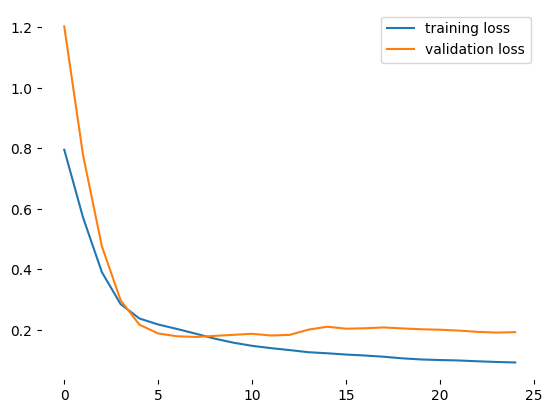

In [165]:
plt.plot(history10.history['loss'], label = 'training loss')
plt.plot(history10.history['val_loss'], label ='validation loss')
plt.legend()
plt.show()

In [166]:
history10 = models.load_model('model10.keras')

In [167]:
result10 = model10.evaluate(X_test, y_test.reshape(-1, n_steps_out*len(columns)))
y_test_pred_model10 = model10.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1619  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


In [168]:
y_test_pred_model10 = y_test_pred_model10.reshape(-1, n_steps_out, len(columns))
iterations = TEST_SIZE // n_steps_out + 1
remain = TEST_SIZE % n_steps_out

y_price_test_pred_model10 = []

for i in range(iterations):
    y_price_test_pred_model10 += list(msp_data_model.scaler.inverse_transform(y_test_pred_model10[i*n_steps_out]).T[0])
    
if remain != 0:
    y_price_test_pred_model10 += list(msp_data_model.scaler.inverse_transform(y_test_pred_model10[-1]).T[0][-remain+1:])

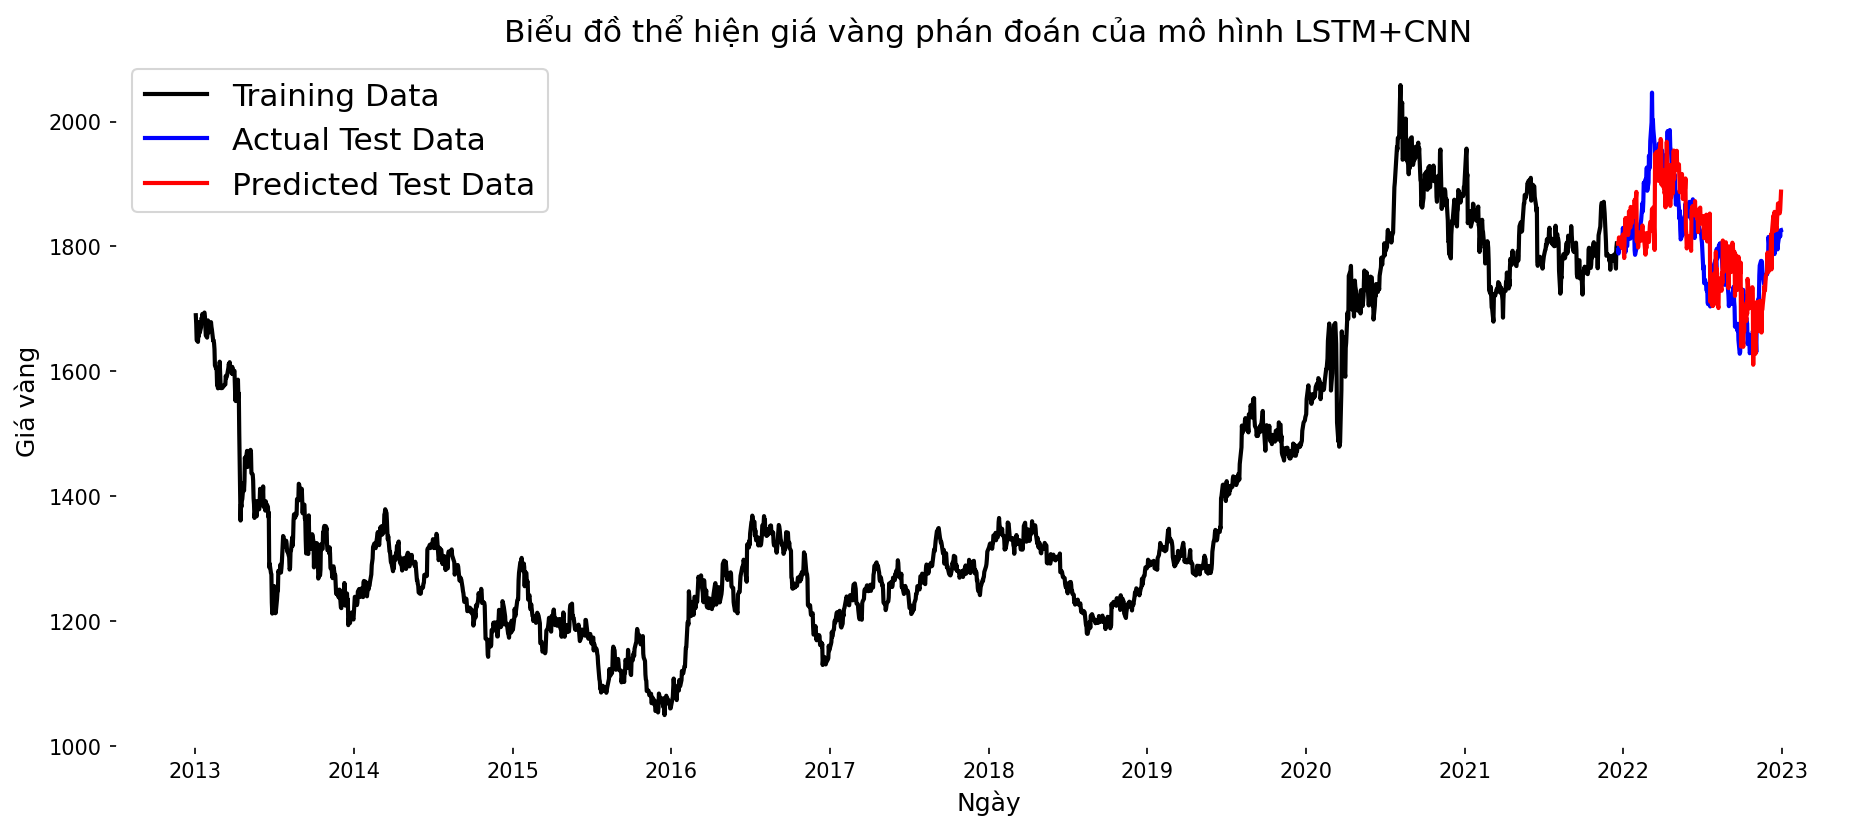

In [169]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-(TEST_SIZE+n_steps_out-1)], df['Price'].iloc[:-(TEST_SIZE+n_steps_out-1)], color='black', lw=2)
plt.plot(df['Date'].iloc[-(TEST_SIZE+n_steps_out-1):], df['Price'].iloc[-(TEST_SIZE+n_steps_out-1):], color='blue', lw=2)
plt.plot(df['Date'].iloc[-(TEST_SIZE+n_steps_out-1):], y_price_test_pred_model10, color='red', lw=2)
plt.title('Biểu đồ thể hiện giá vàng phán đoán của mô hình LSTM+CNN', fontsize=15)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá vàng', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [170]:
print('MAPE: {}'.format(mean_absolute_percentage_error(df['Price'].iloc[-(TEST_SIZE+n_steps_out-1):].values, y_price_test_pred_model10)))
print('Accuracy: {}'.format((1 - mean_absolute_percentage_error(df['Price'].iloc[-(TEST_SIZE+n_steps_out-1):].values, y_price_test_pred_model10))*100))

MAPE: 0.026610541624381638
Accuracy: 97.33894583756184


In [171]:
metric_df_multi_steps.loc[len(metric_df_multi_steps.index)] = measure_metric(df['Price'].iloc[-(TEST_SIZE+n_steps_out-1):].values, y_price_test_pred_model10)

R2: 0.5382892617238074
MSE: 3728.4236496158437
RMSE: 61.06081926747989
MAE: 47.944818414652126
MAPE: 0.026610541624381638


In [172]:
n_steps_prediction_model10 = msp_data_model.multi_step_forecast(model10, n_steps_data, n_iters)

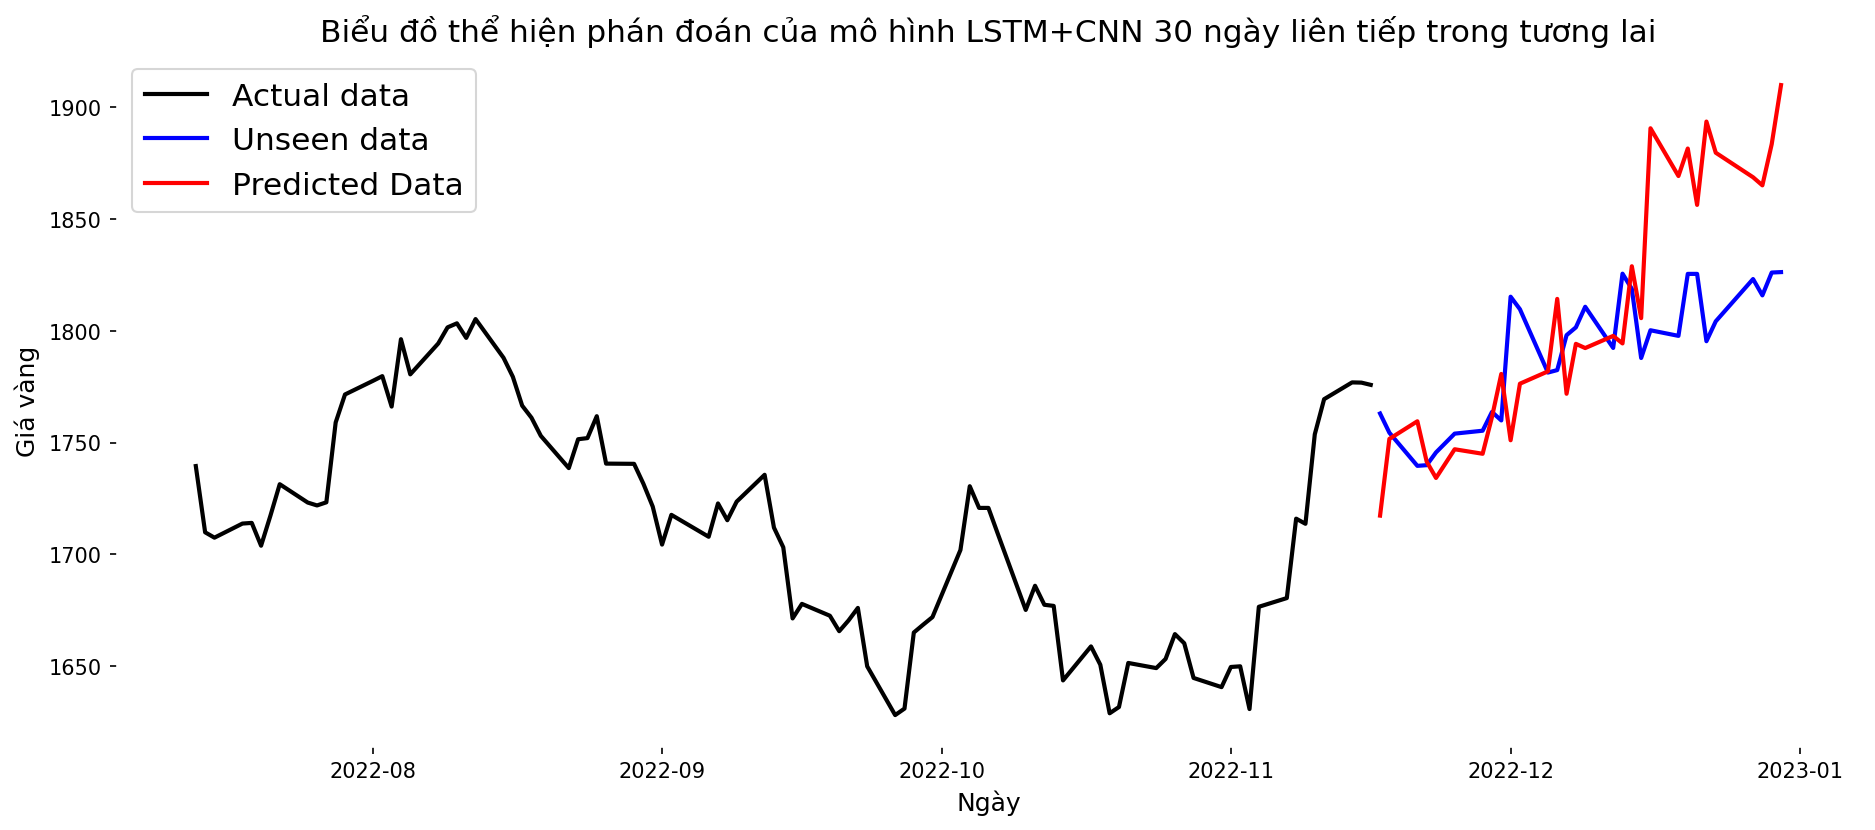

In [173]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[-(n_steps_in + n_steps_out * n_iters): -(n_steps_out * n_iters)], df['Price'].iloc[-(n_steps_in + n_steps_out * n_iters): -(n_steps_out * n_iters)], color='black', lw=2)
plt.plot(df['Date'].iloc[-(n_steps_out * n_iters):], df['Price'].iloc[-(n_steps_out * n_iters):], color='blue', lw=2)
plt.plot(df['Date'].iloc[-(n_steps_out * n_iters):], n_steps_prediction_model10, color='red', lw=2)
plt.title(f'Biểu đồ thể hiện phán đoán của mô hình LSTM+CNN {n_steps_out * n_iters} ngày liên tiếp trong tương lai', fontsize=15)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá vàng', fontsize=12)
plt.legend(['Actual data', 'Unseen data', 'Predicted Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [174]:
print(f"Biên độ giao động của giá trị dự báo xung quanh giá trị thực tế là {((df['Price'].iloc[-(n_steps_out * n_iters):].values - n_steps_prediction_model10) **2).mean()**(1/2)}")

Biên độ giao động của giá trị dự báo xung quanh giá trị thực tế là 44.491136104106374


In [175]:
metric_df_multi_steps.index = index_model
metric_df_multi_steps

,R2,MSE,RMSE,MAE,MAPE
LSTM,0.677554,2603.825550,51.027694,40.007224,0.022451
GRU,0.746600,2046.268897,45.235704,34.680998,0.019342
BiLSTM,0.711664,2328.383248,48.253324,38.234739,0.021348
CNN,0.514699,3918.919380,62.601273,50.939621,0.028240
CNN+LSTM,0.538289,3728.423650,61.060819,47.944818,0.026611
